 # Evaluating Hospital Effectiveness - Data Exploration, Modeling, and Interpretation

Thien Nguyen

In the previous notebook, data was constructed from the combination of five datasets documenting attributes of different hospitals nationwide. The dataset were combined in such a way that gave every provider their own entry (row). However, the great number of missing data proved challenging to overcome; KNN imputation and pseudolabeling were used to fill in missing values, but given that about 1/3 of the entire dataframe was missing, this will inevitably skew results. Therefore, the following steps of modeling and interpretation will be applied to both imputed datasets as well as a selective dataset with no missing values.

In [340]:
# Import necessary packages that can be updated retroactively
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import statsmodels.api as smf
from datetime import datetime
import scipy.stats as st
from sklearn.naive_bayes import GaussianNB
#from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree, svm, cross_validation
import xgboost as xgb
from sklearn.cluster import KMeans
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import timeit

%matplotlib inline

## Exploratory Data Analysis

For basic data exploration, we'll only need to look at one dataframe. Since the imputed dataframe includes the pure dataframe, it will be the one we examine.

In [243]:
df = pd.read_csv('knn_df.csv')
pure_df = pd.read_csv('pure_df.csv')

In [244]:
df = df.astype({'Provider_ID': str})
pure_df = df.astype({'Provider_ID': str})

In [245]:
#Create a split of about 90:10
test = pure_df.iloc[:418]
train = df.drop(test.index, axis =0)

print(train.shape)
print(test.shape)

(4026, 130)
(418, 130)


In [246]:
train.reset_index(inplace=True, drop=True)

In [247]:
train.describe()

#set provider as index 

Rate of complications for hip/knee replacement patients_Denominator  \
count                                        4026.000000                     
mean                                          346.644438                     
std                                           360.735515                     
min                                            25.000000                     
25%                                           139.000000                     
50%                                           355.680874                     
75%                                           355.680874                     
max                                          9221.000000                     

       Rate of complications for hip/knee replacement patients_Score  \
count                                        4026.000000               
mean                                            2.586669               
std                                             0.424708               
min                                             1.300000               
25%                                             2.400000               
50%                                             2.587723               
75%                                             2.700000               
max                                            11.000000               

       Rate of complications for hip/knee replacement patients_Lower Estimate  \
count                                        4026.000000                        
mean                                            1.600613                        
std                                             0.302791                        
min                                             0.900000                        
25%                                             1.437504                        
50%                                             1.607322                        
75%                                             1.607322                        
max                                             8.700000                        

       Rate of complications for hip/knee replacement patients_Higher Estimate  \
count                                        4026.000000                         
mean                                            4.174558                         
std                                             0.712366                         
min                                             1.700000                         
25%                                             3.933812                         
50%                                             4.161275                         
75%                                             4.400000                         
max                                            13.900000                         

       Death rate for heart attack patients_Denominator  \
count                                       4026.000000   
mean                                         188.881249   
std                                          135.771096   
min                                           25.000000   
25%                                           95.000000   
50%                                          203.828118   
75%                                          203.828118   
max                                         1553.000000   

       Death rate for heart attack patients_Score  \
count                                 4026.000000   
mean                                    12.852146   
std                                      0.770400   
min                                      8.900000   
25%                                     12.700000   
50%                                     12.838563   
75%                                     13.020637   
max                                     17.200000   

       Death rate for heart attack patients_Lower Estimate  \
count                                        4026.000000     
mean                                           10.14

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000129501B1DD8>,
      dtype=object)

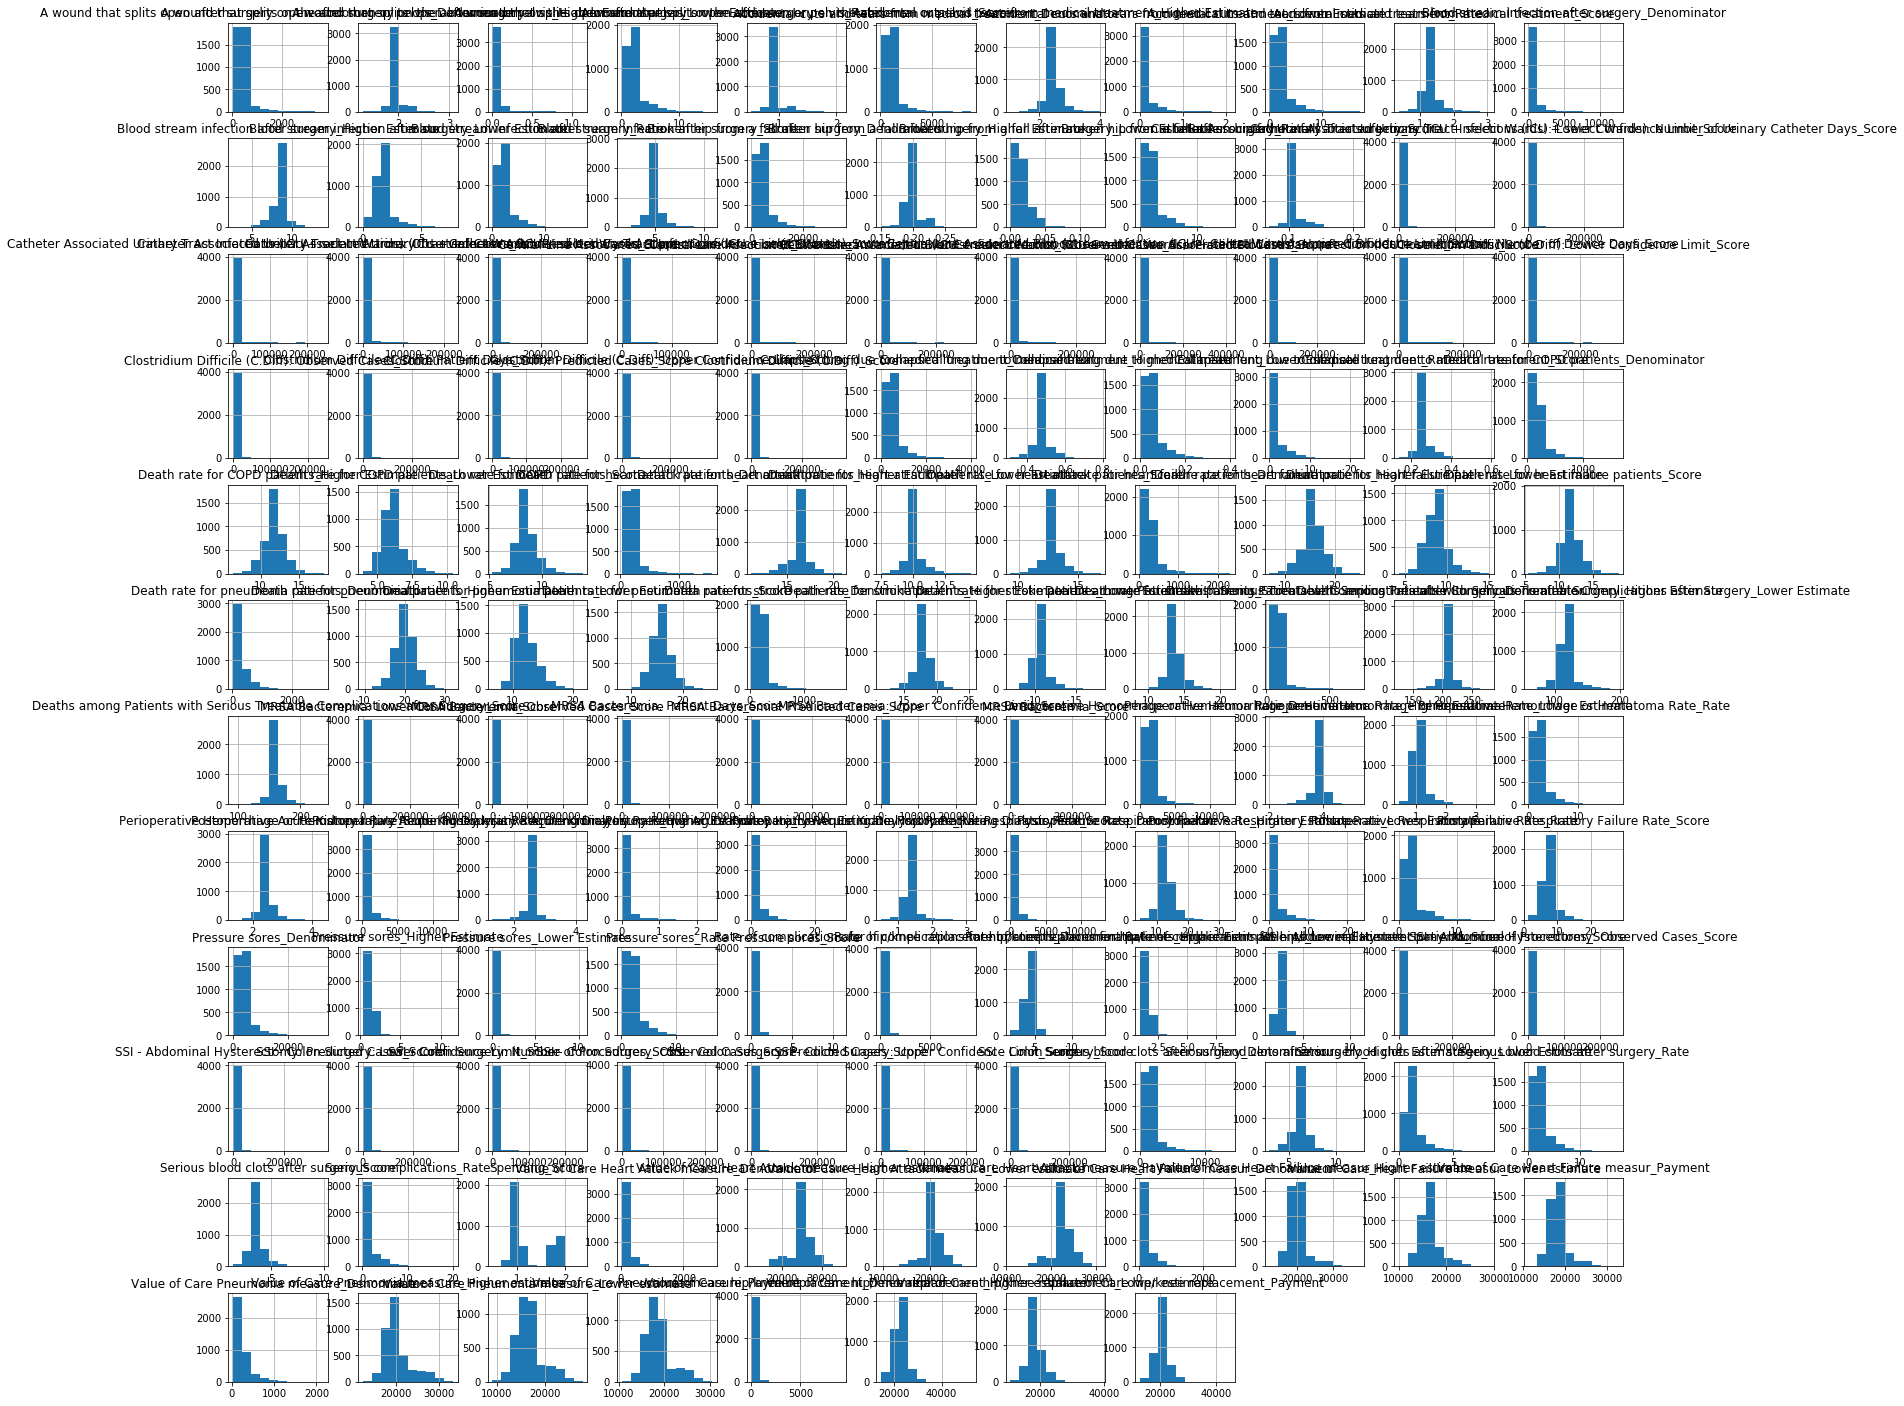

In [27]:
# examine histograms
train.hist(figsize=(25,25))


The data initially seems highly skewed, but it is mainly because it hasn't been scaled yet. 

In [248]:
def scale_features(df):

    #Split into feature and target set

    X = df[df.columns[1:-1]]

    #Scale the features
    X = StandardScaler().fit_transform(X)
    scaled_X = pd.DataFrame(data = X, columns = df.columns[1:-1])
    return scaled_X

scaled_train_X = scale_features(train)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020C8B2B82B0>,
      dtype=object)

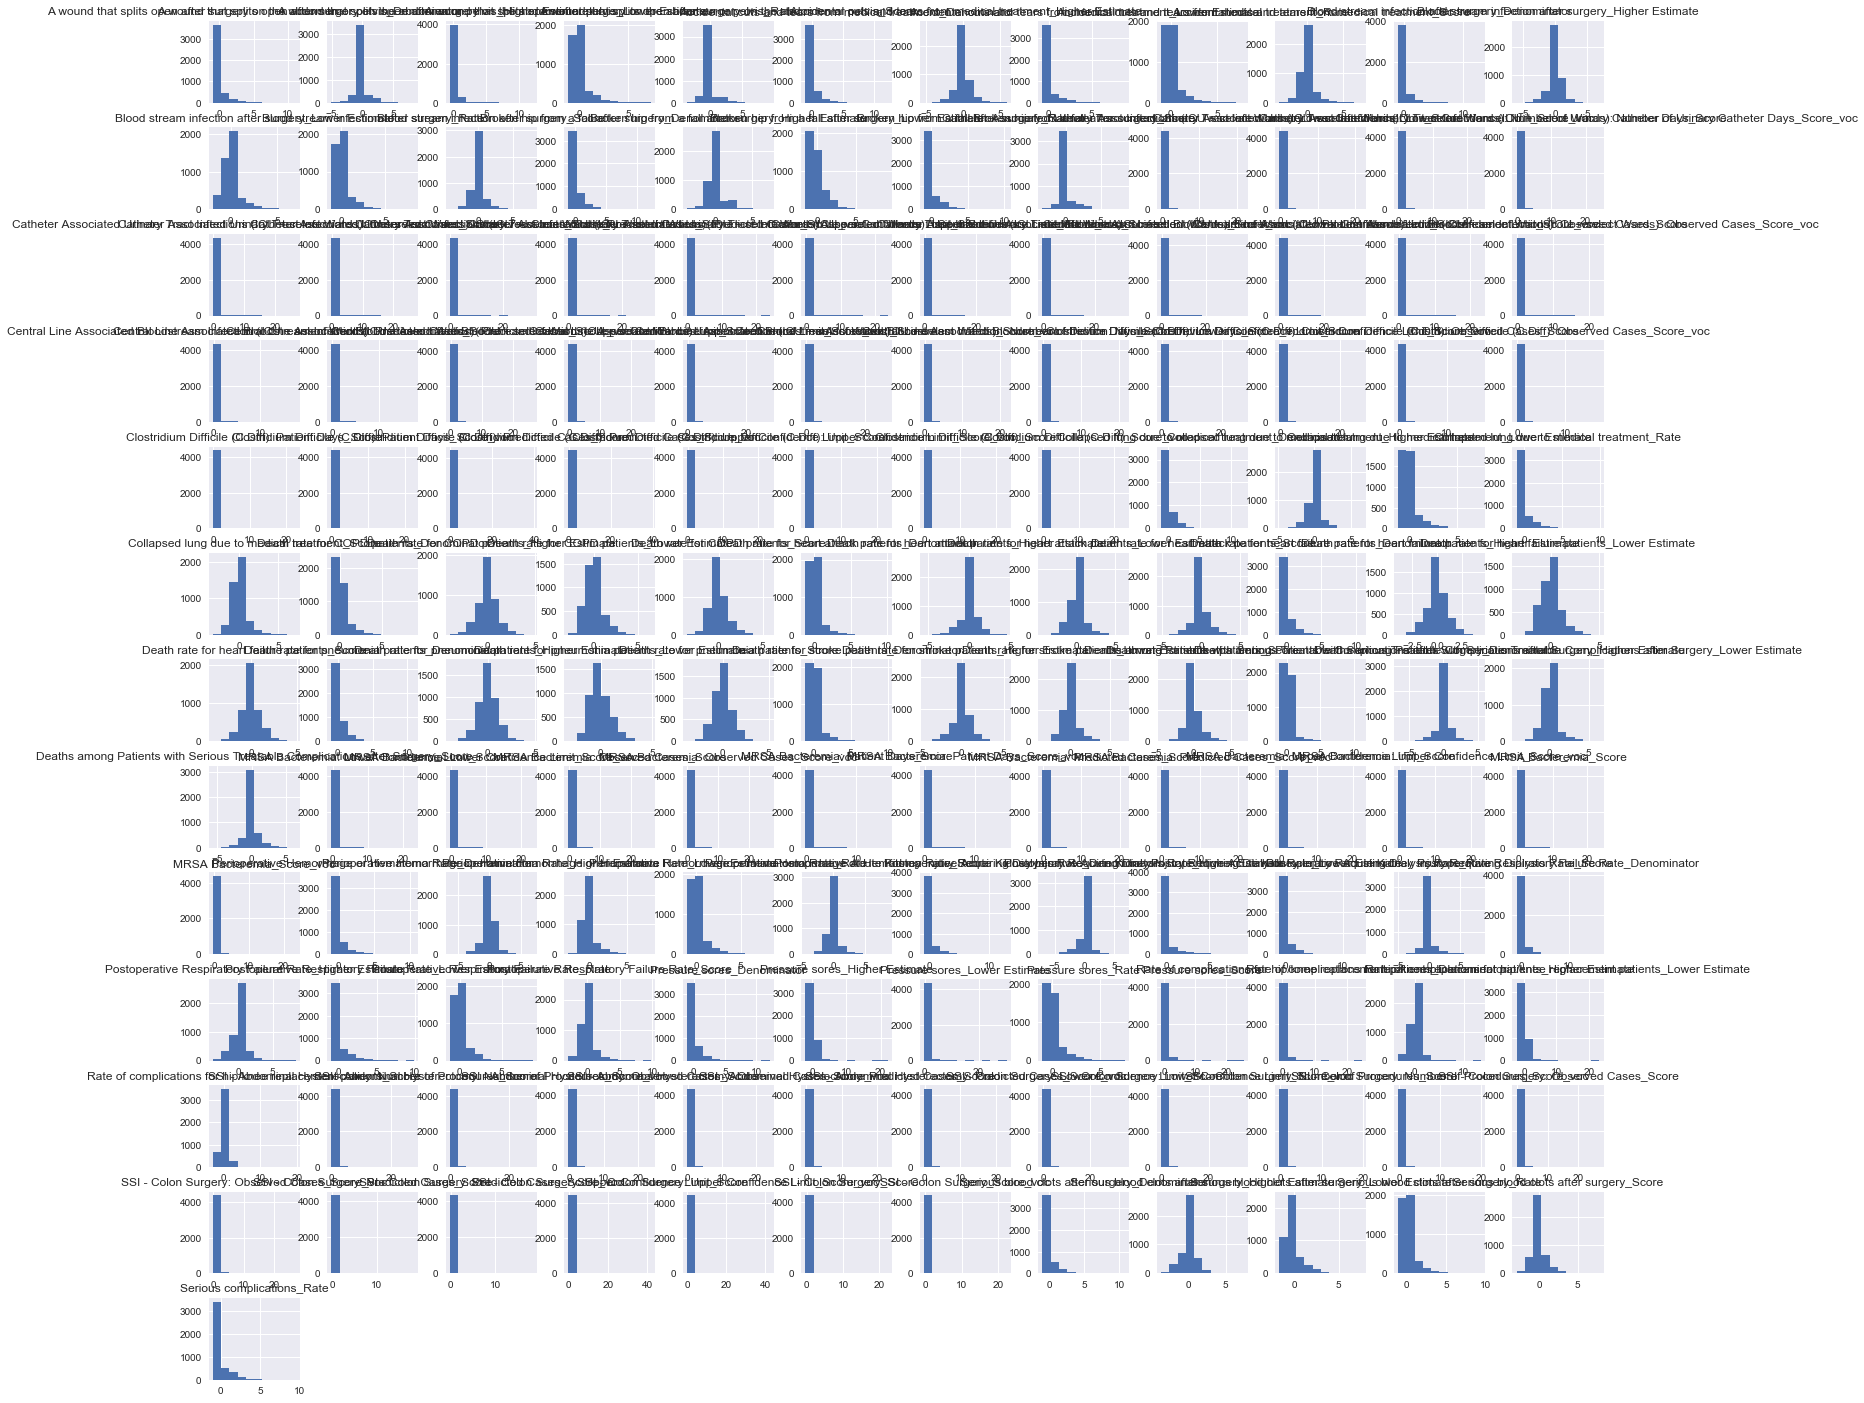

In [90]:
scaled_train_X.hist(figsize=(25,25))

The data is no longer skewed as much, and some features display normal distribution (albeit a bit kurtic). However, many features are still left skewed (presumably 0). 

Looking at jointplots would be good for getting an idea of which variables seem to have the most impact on spending score, but with over 140 features, it would be impractical to visually inspect every feature.

C:\Users\Thien Nguyen\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Thien Nguyen\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\Users\Thien Nguyen\Anaconda3\lib\site-packages\matplotlib\tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decora

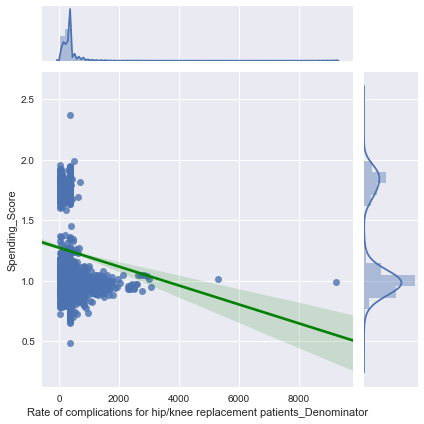

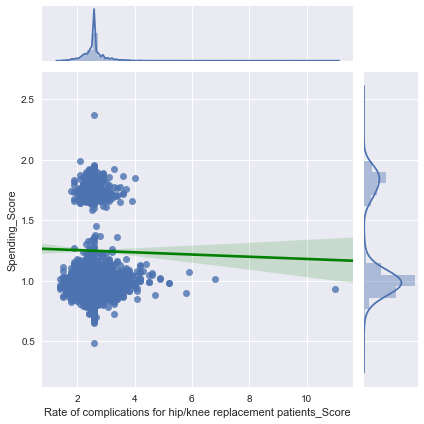

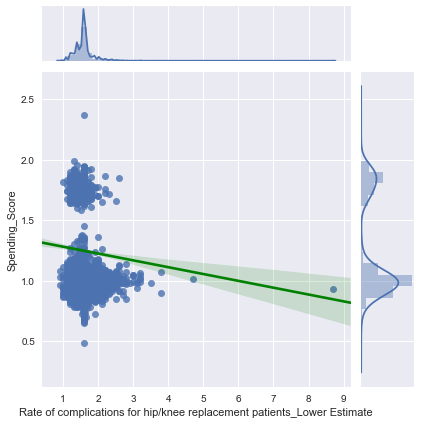

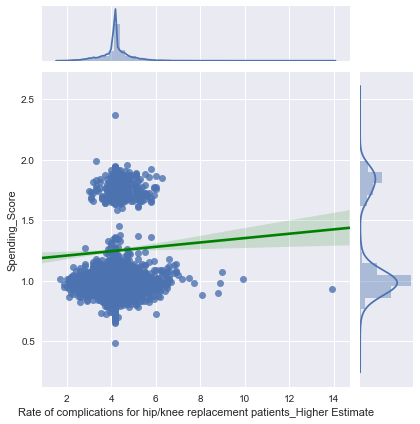

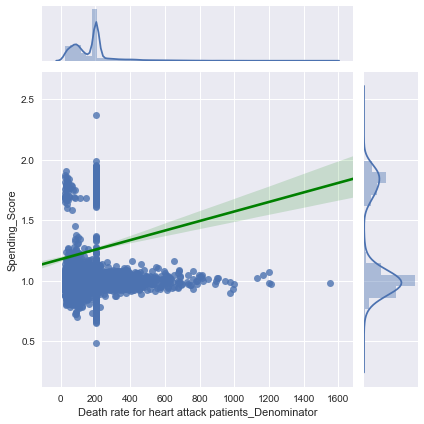

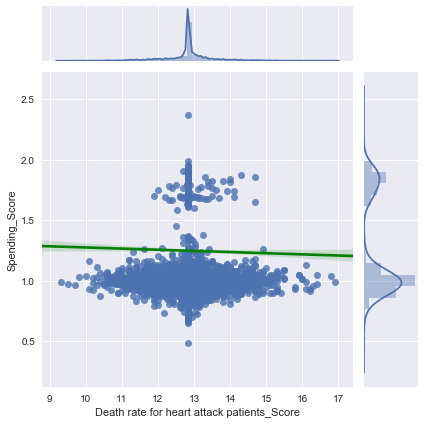

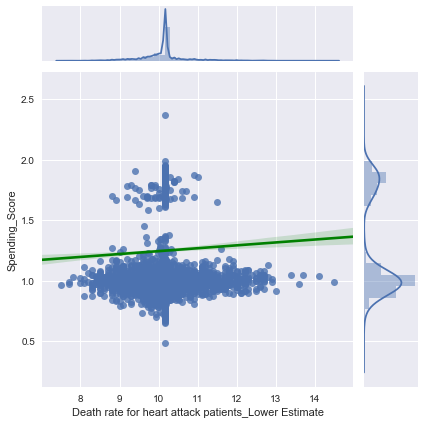

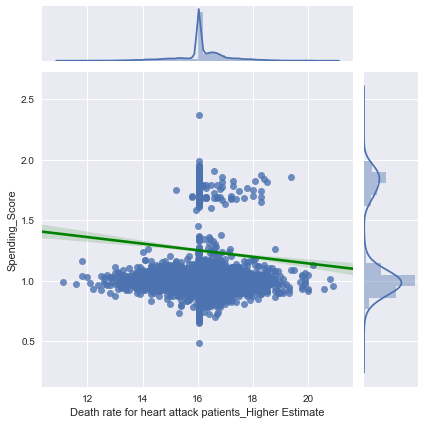

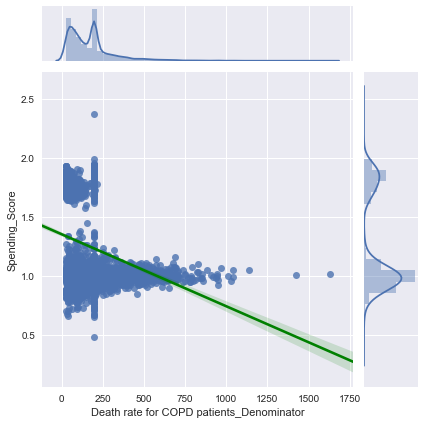

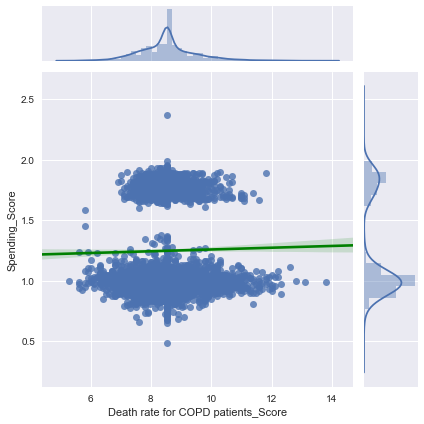

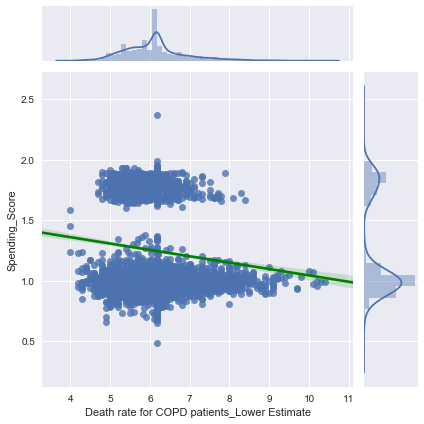

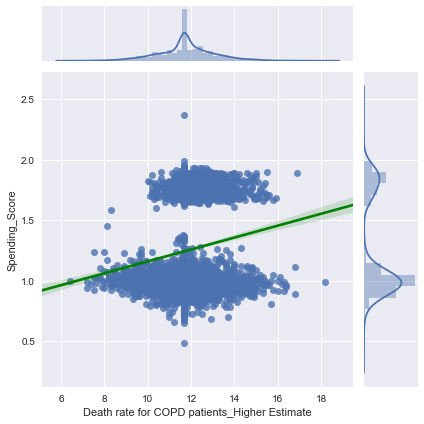

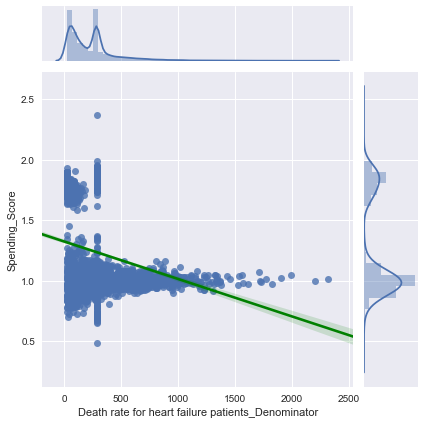

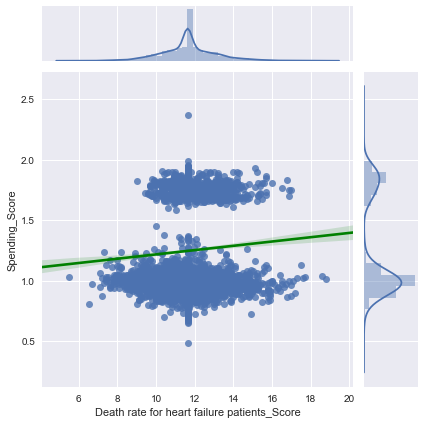

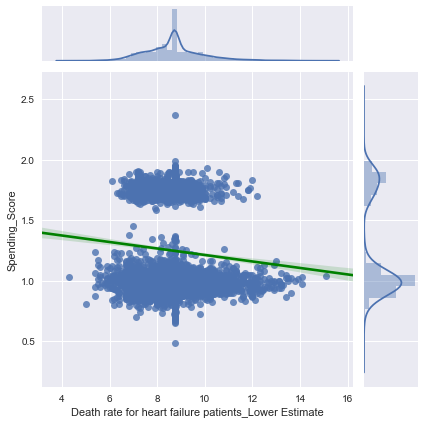

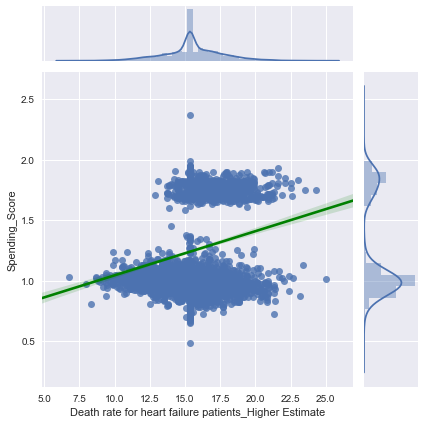

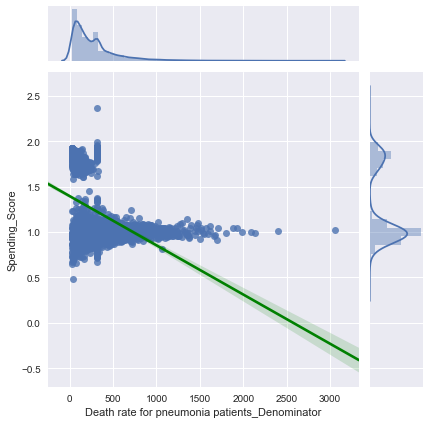

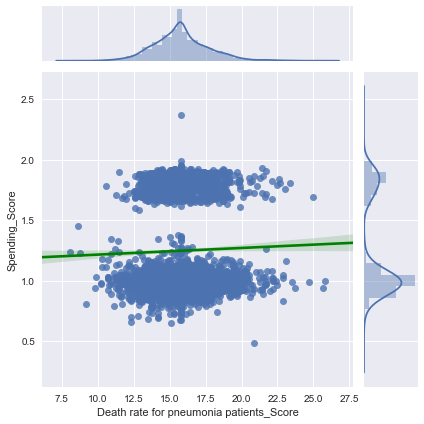

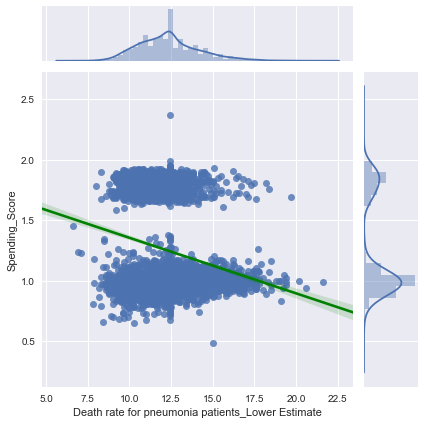

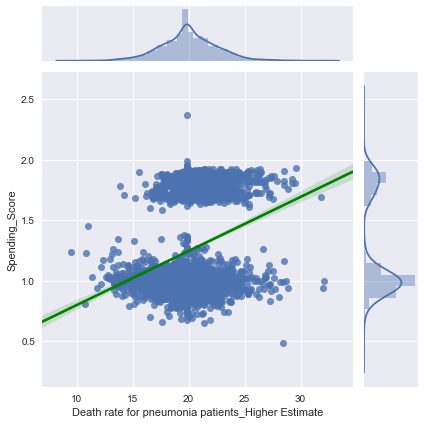

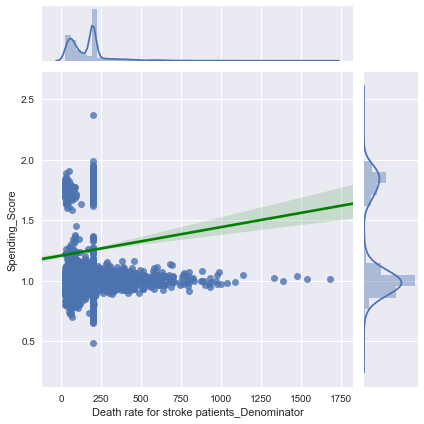

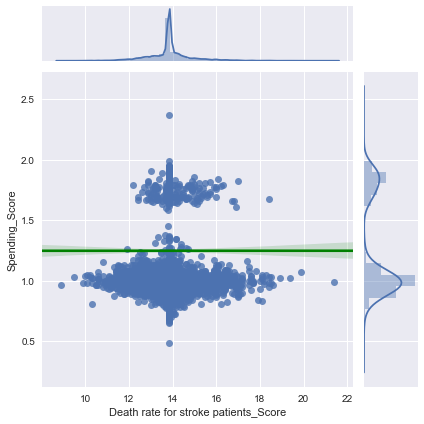

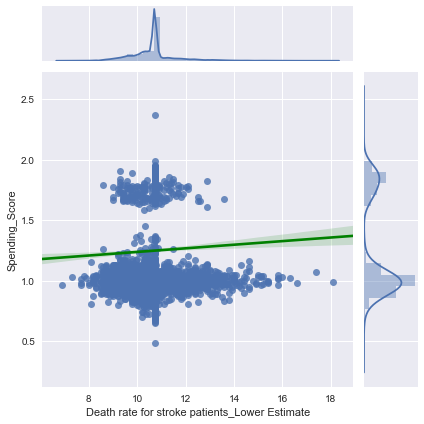

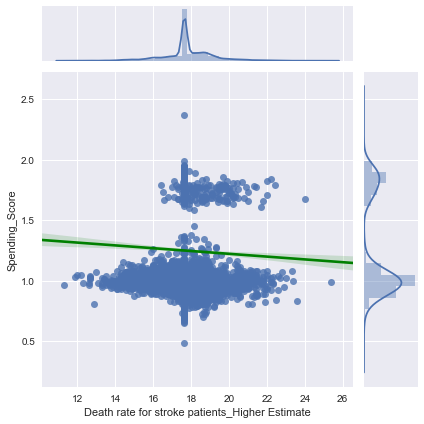

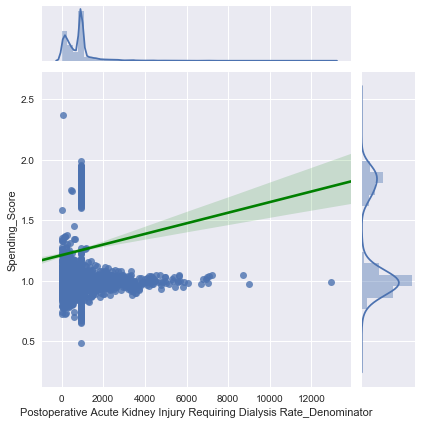

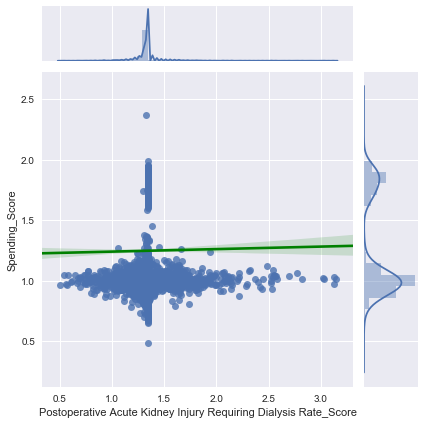

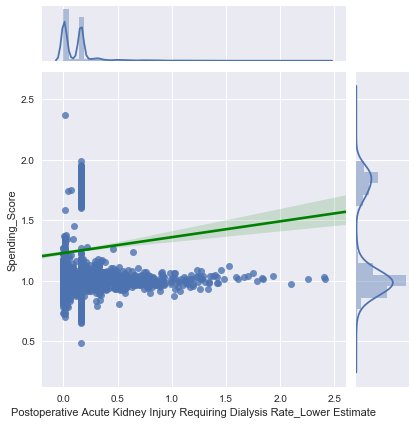

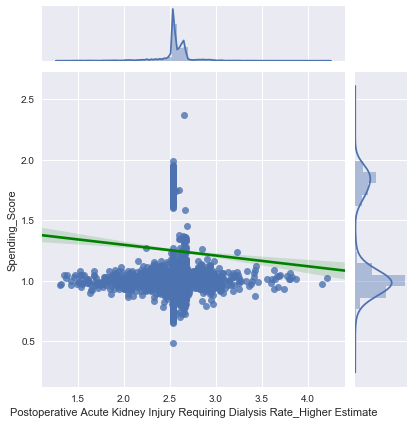

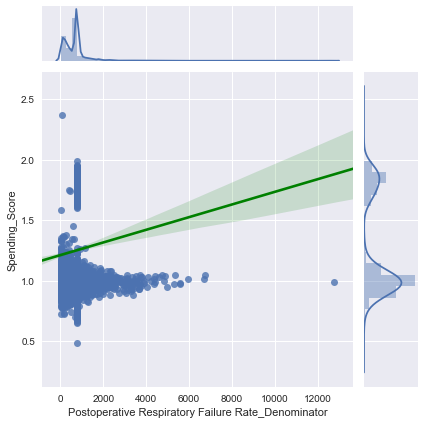

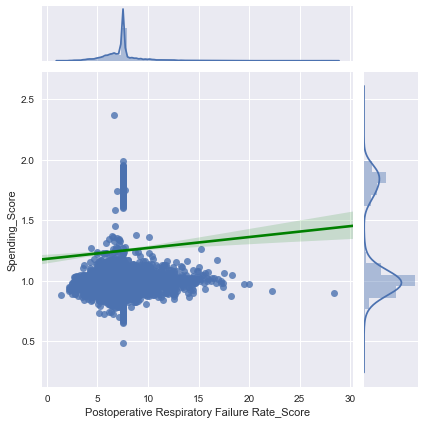

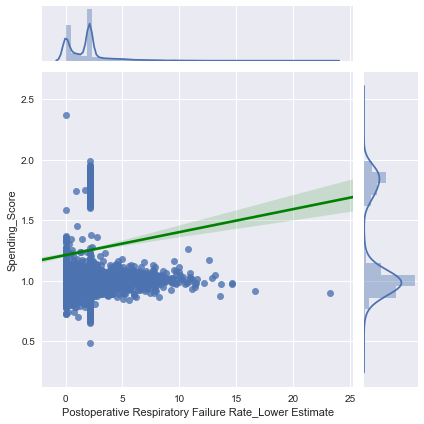

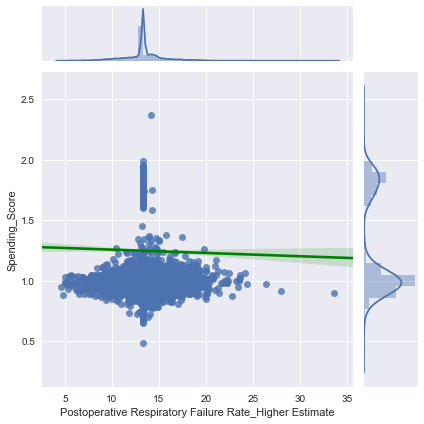

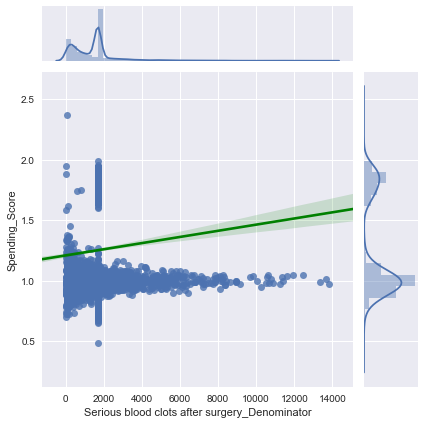

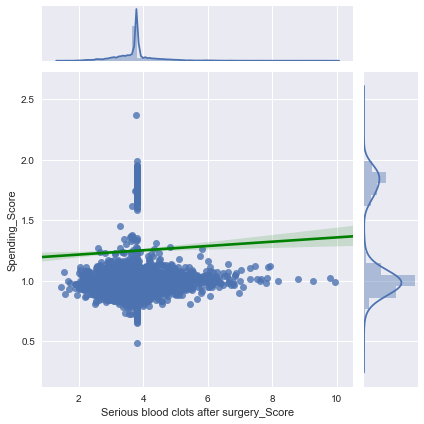

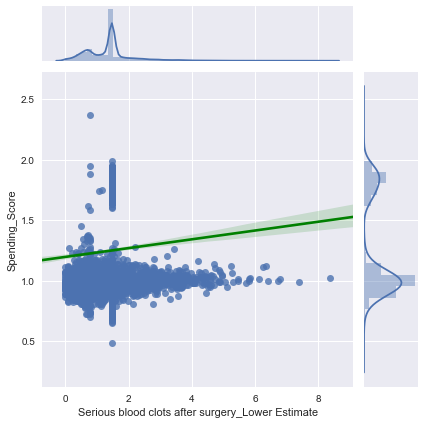

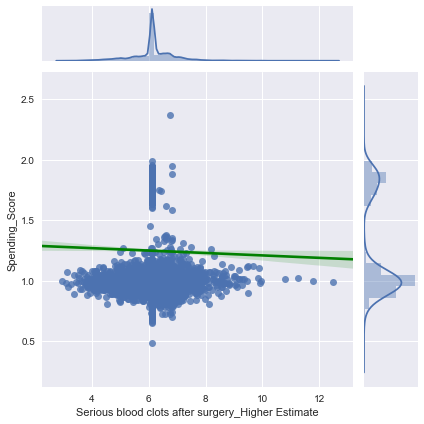

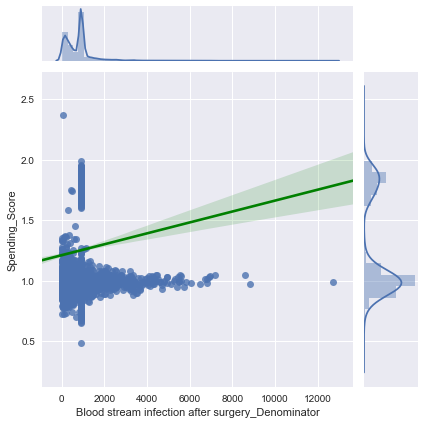

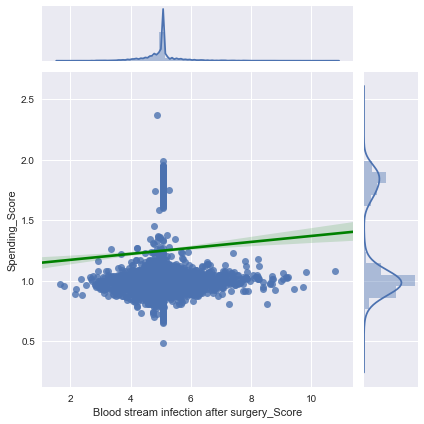

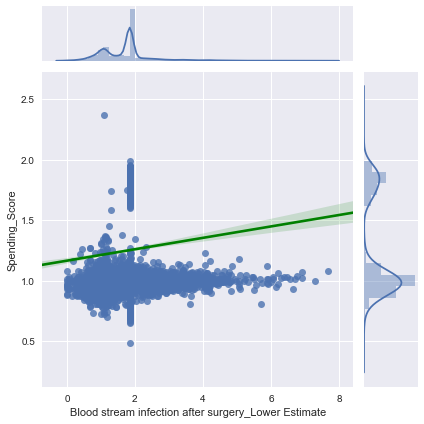

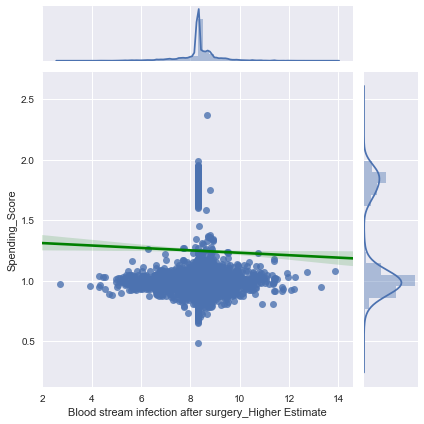

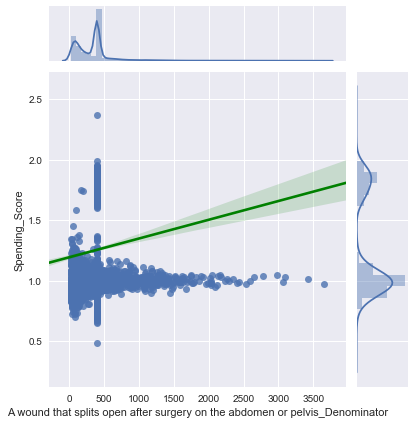

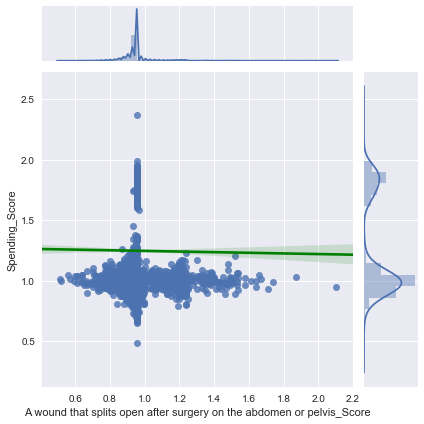

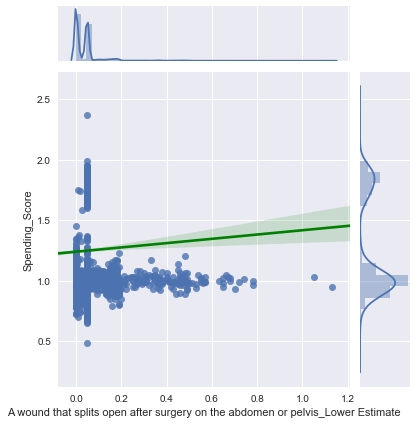

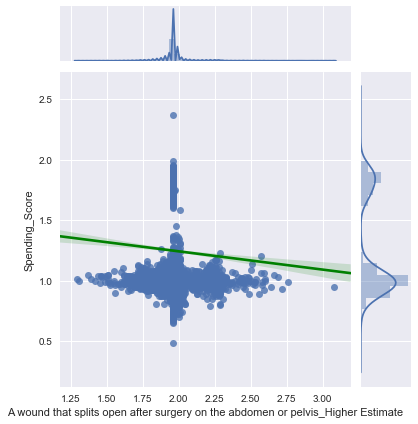

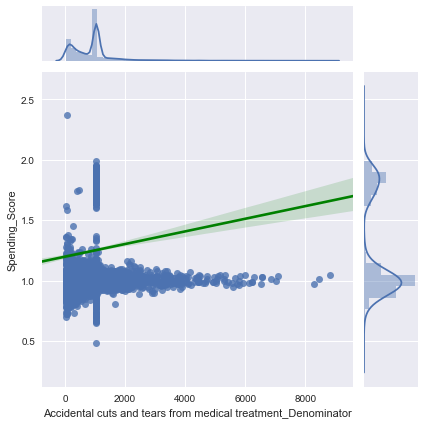

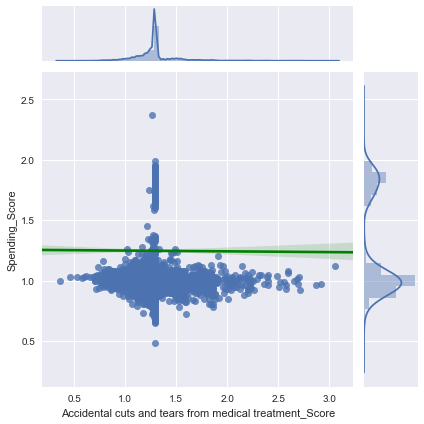

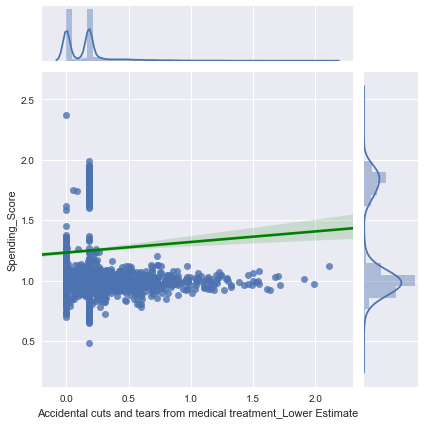

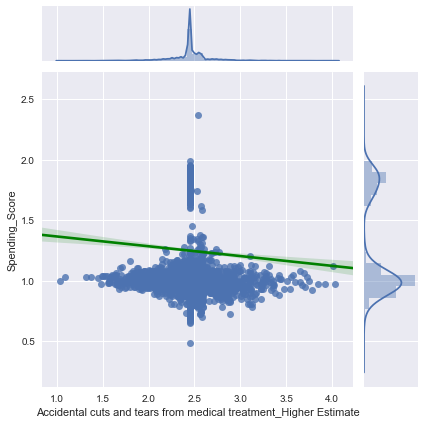

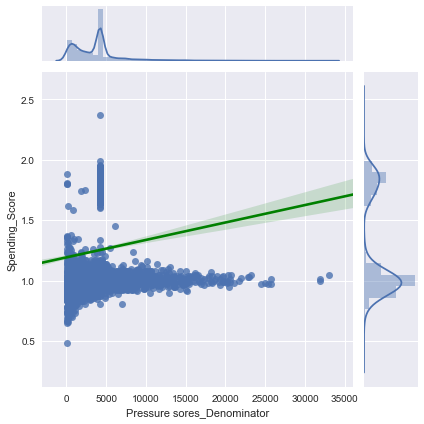

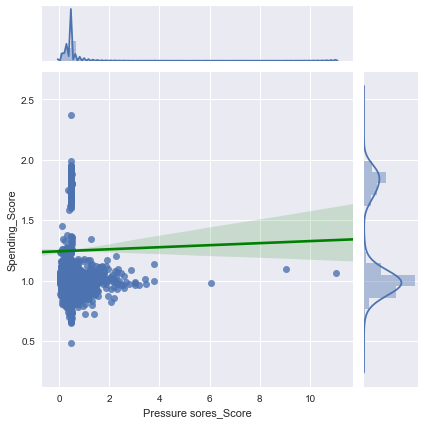

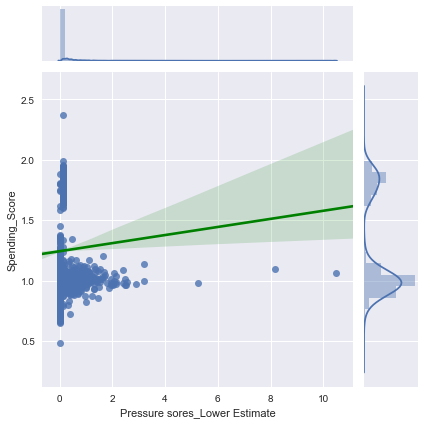

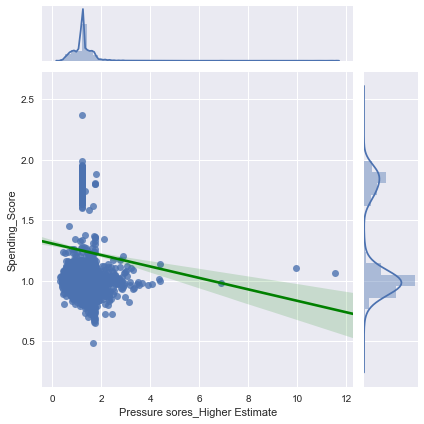

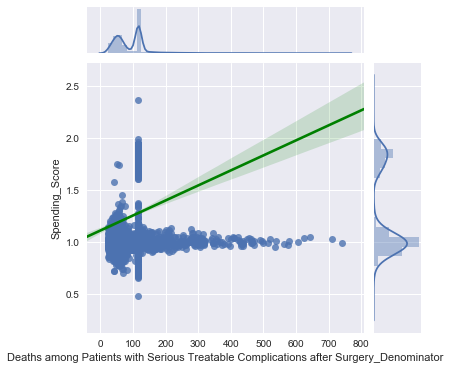

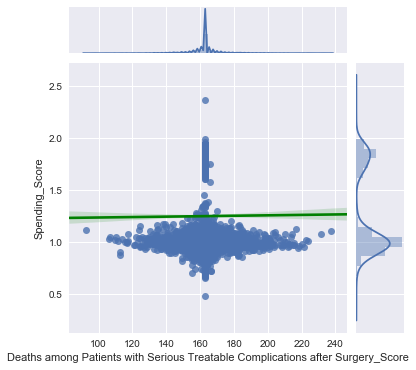

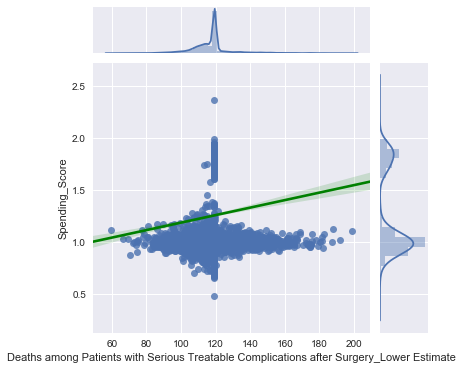

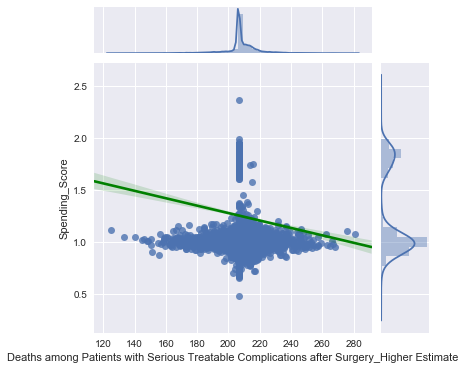

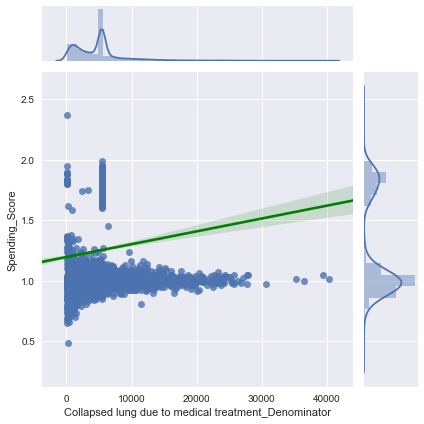

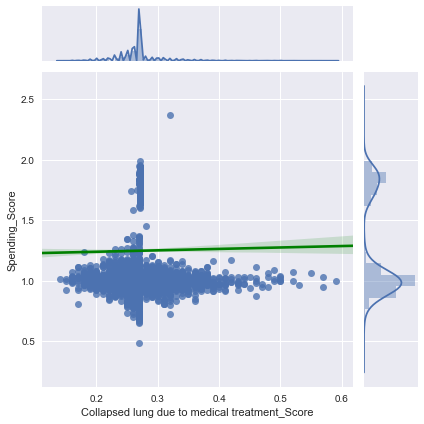

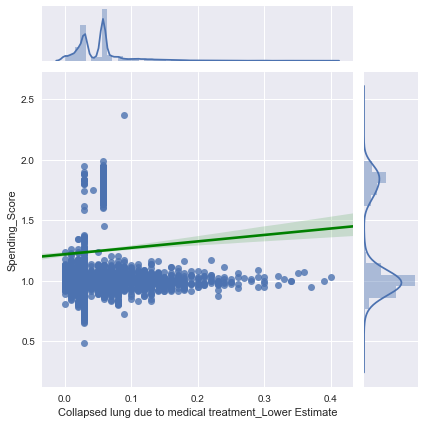

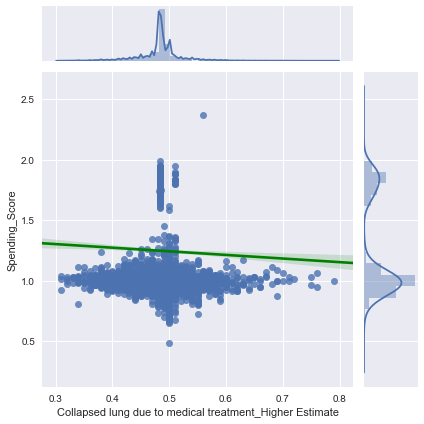

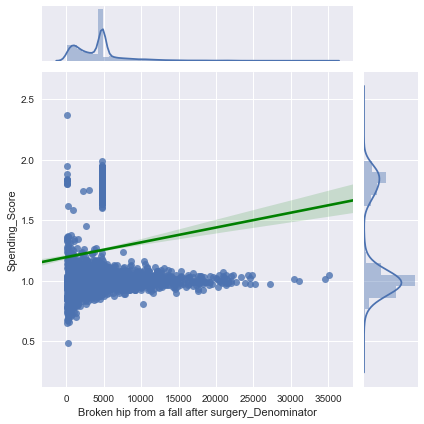

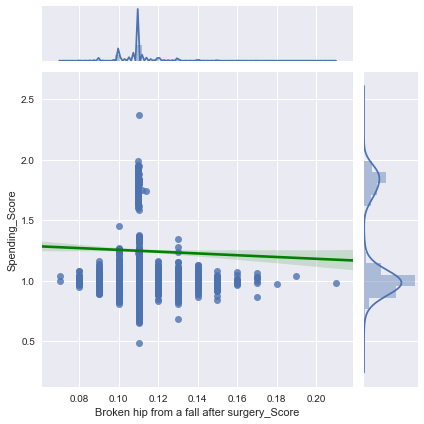

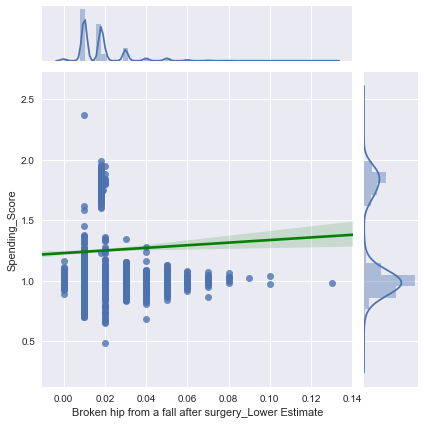

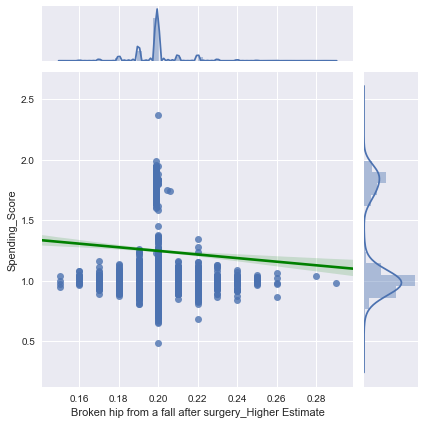

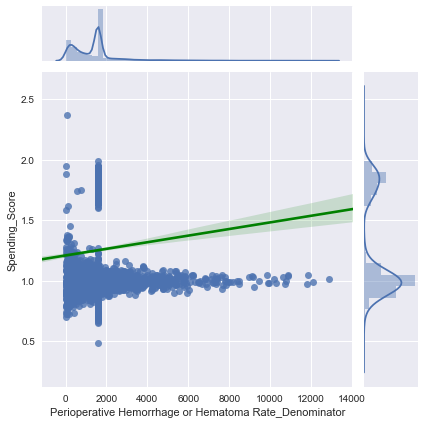

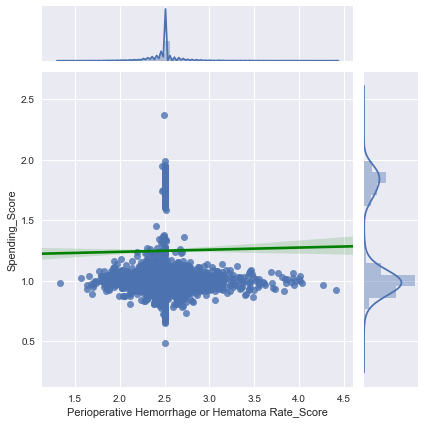

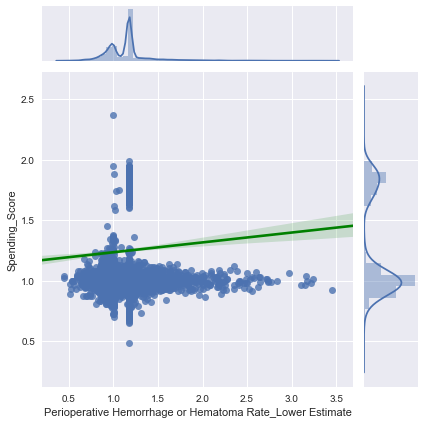

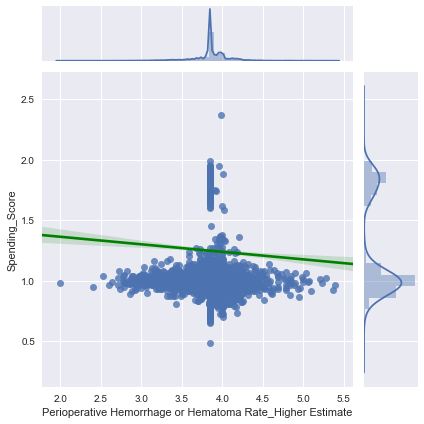

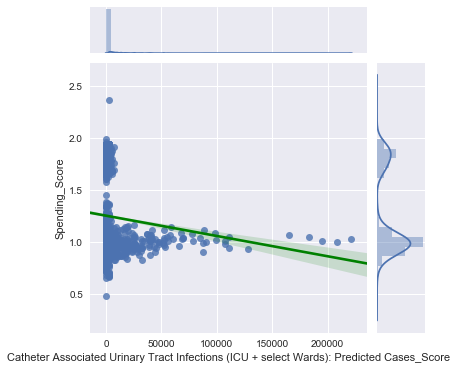

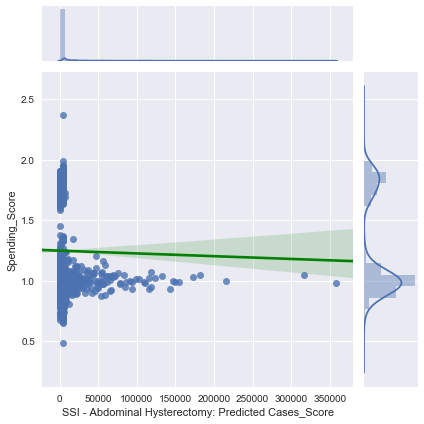

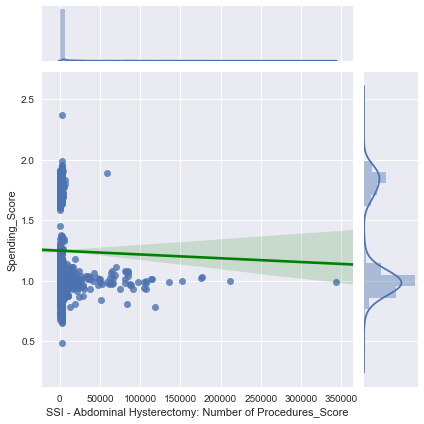

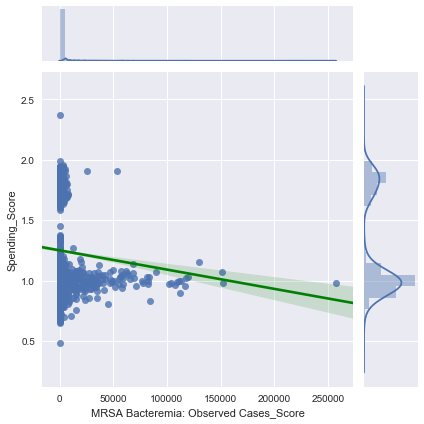

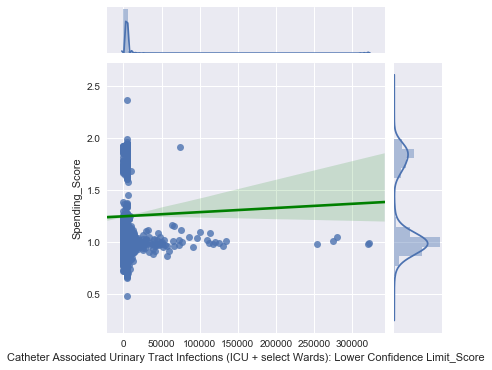

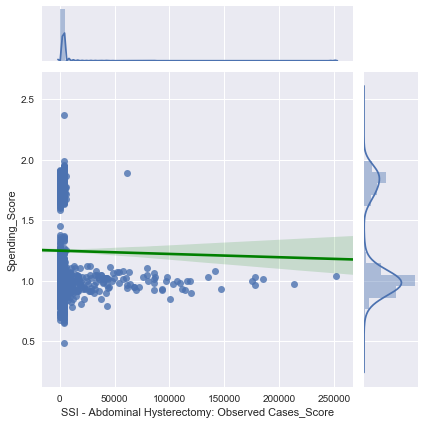

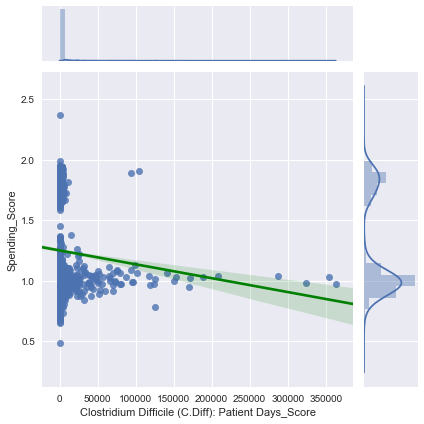

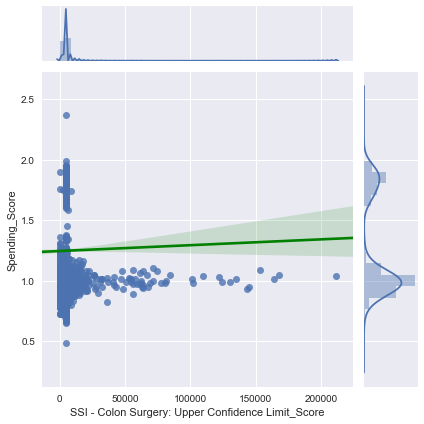

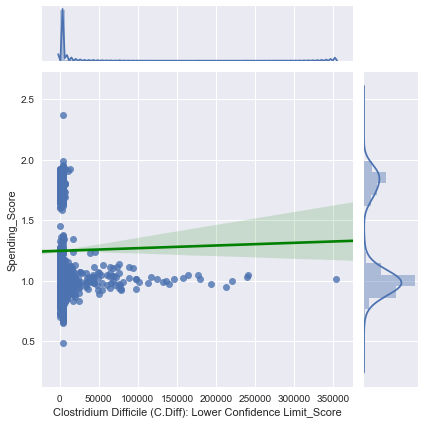

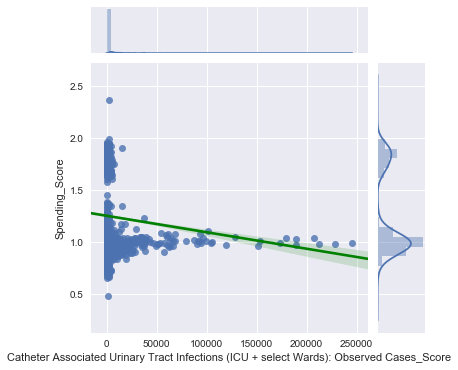

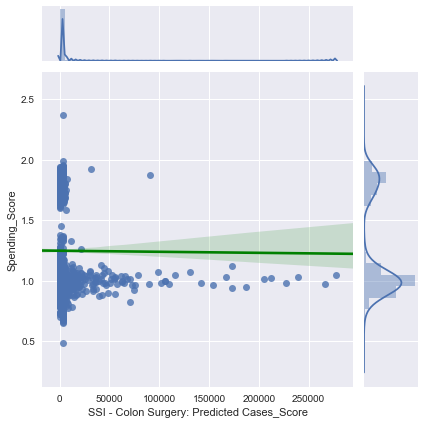

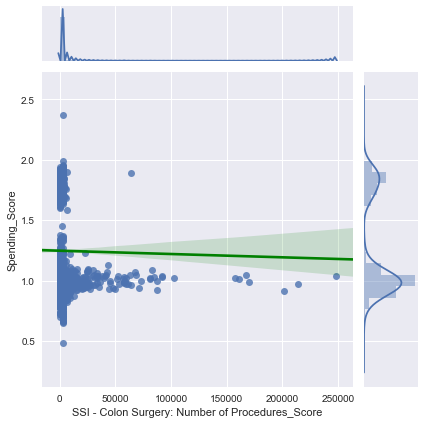

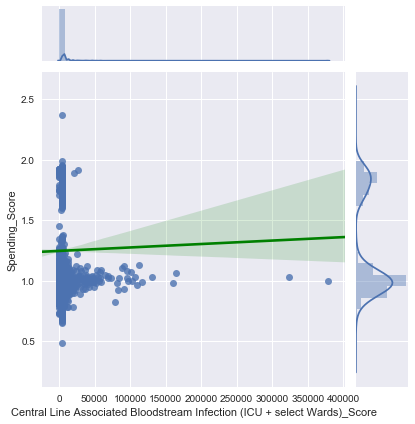

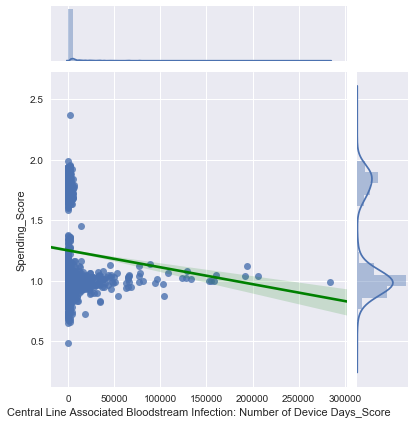

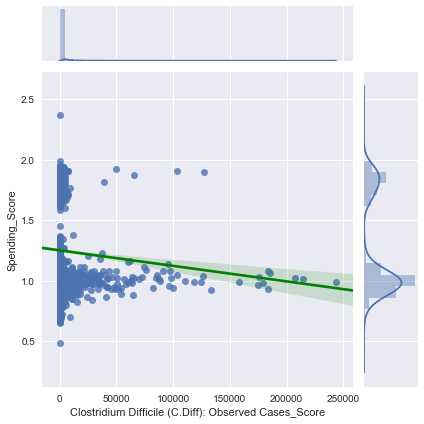

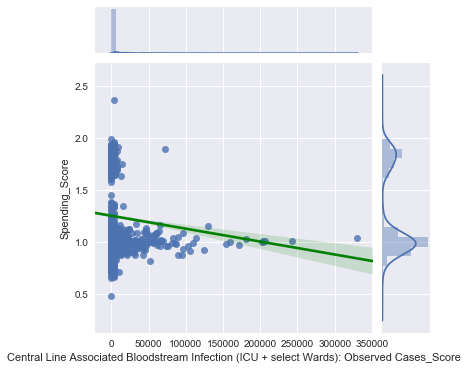

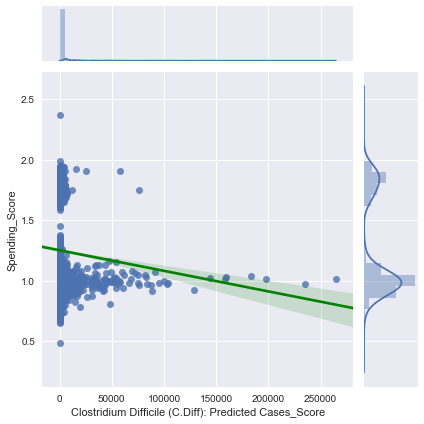

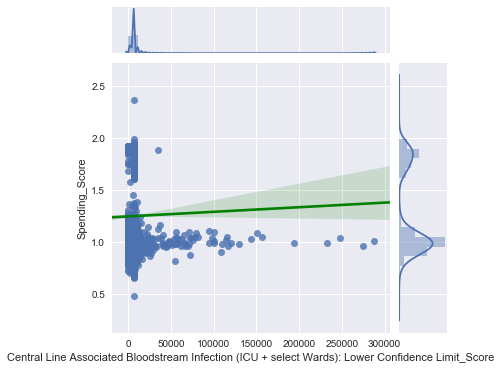

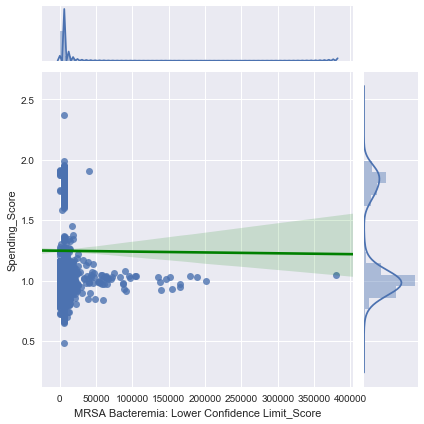

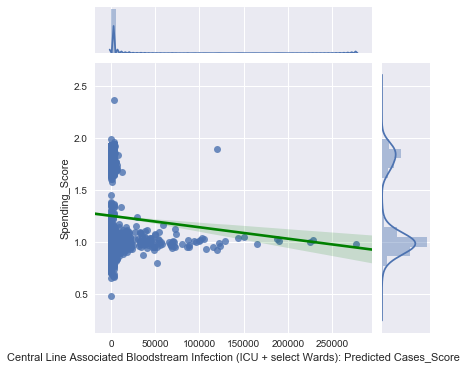

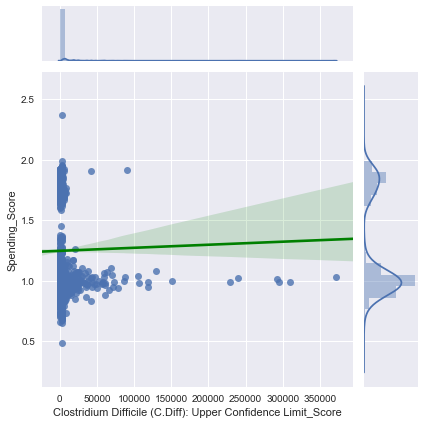

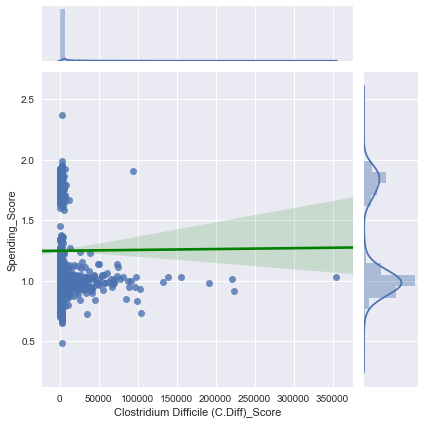

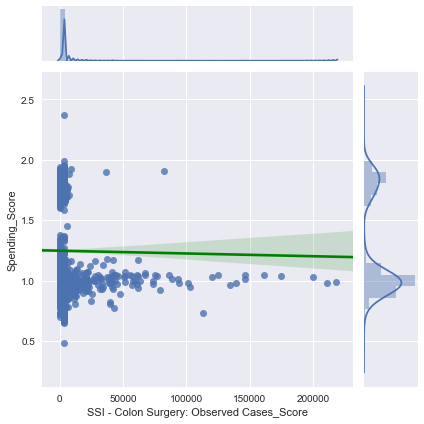

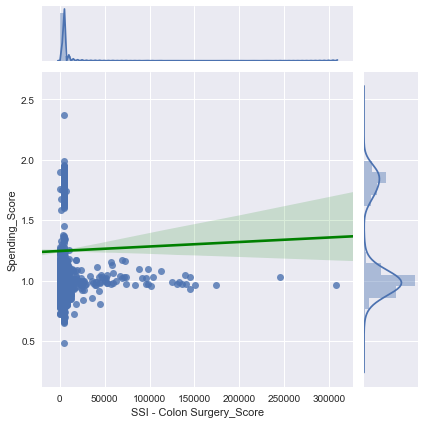

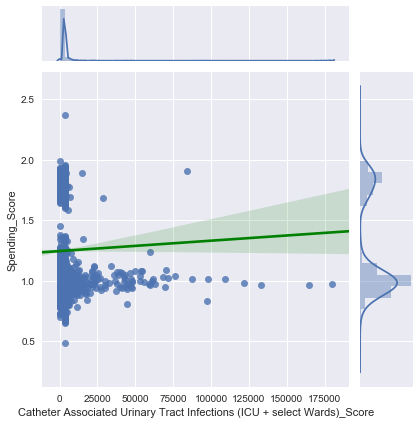

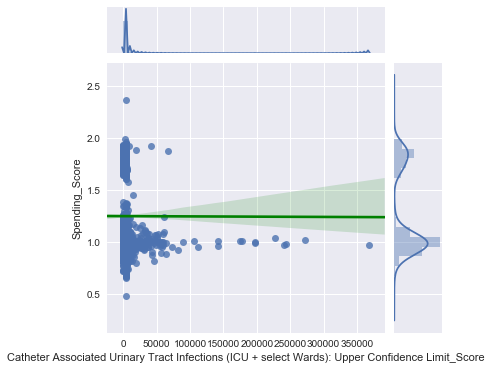

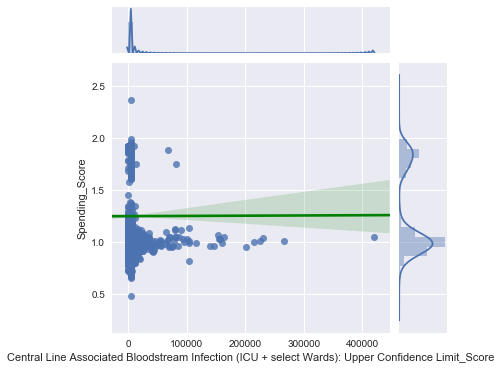

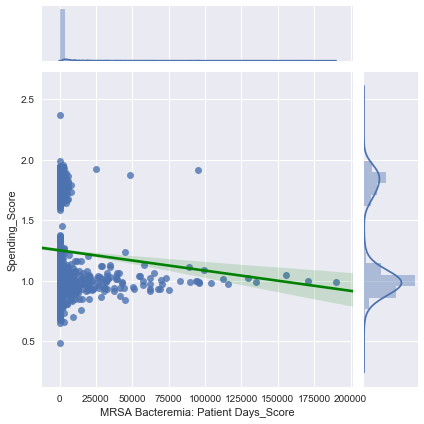

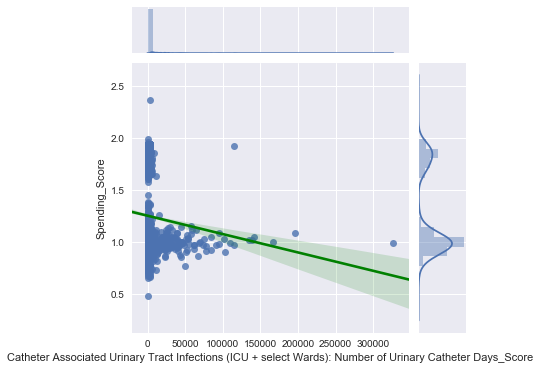

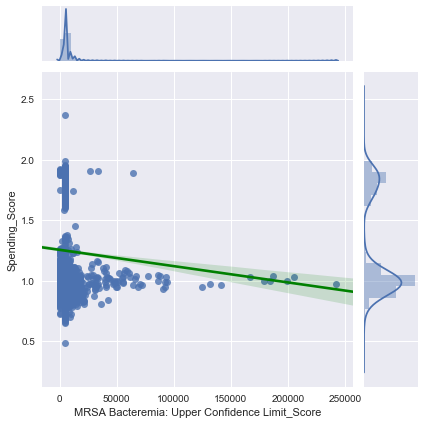

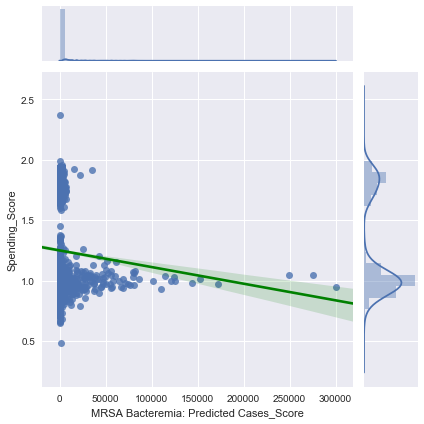

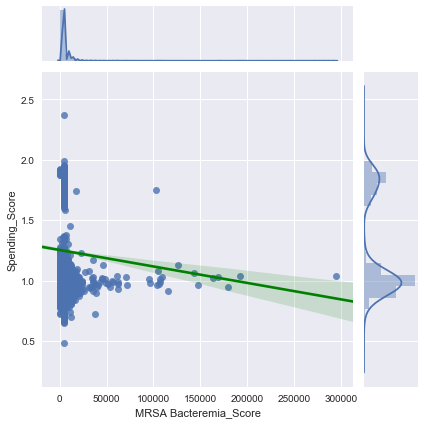

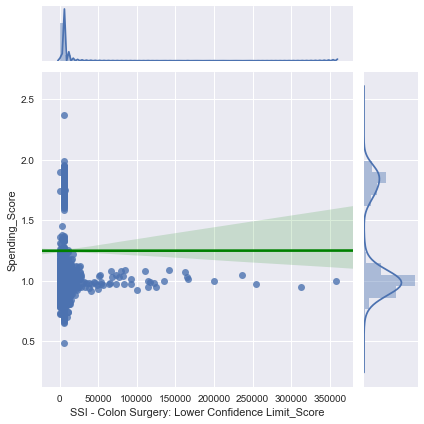

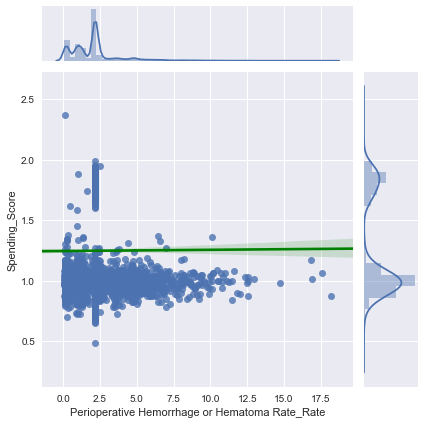

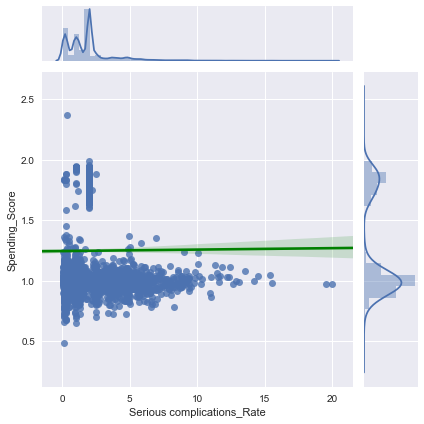

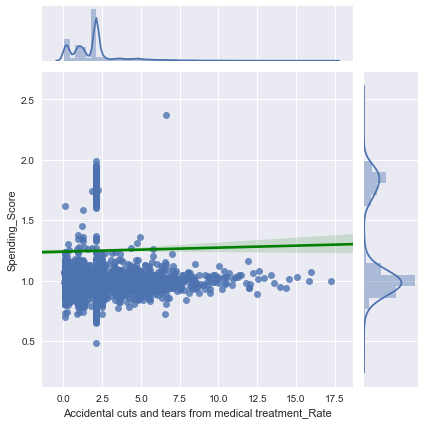

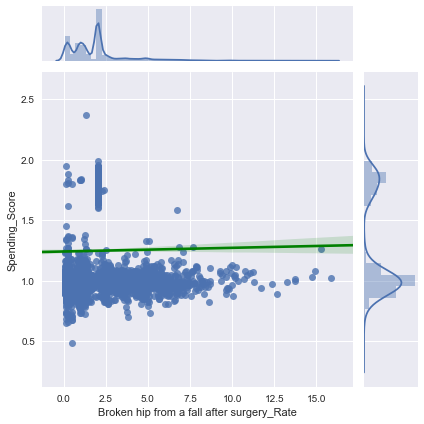

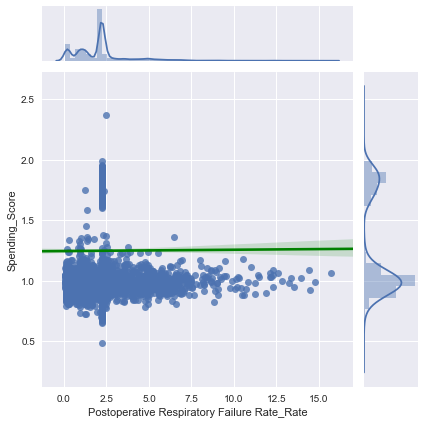

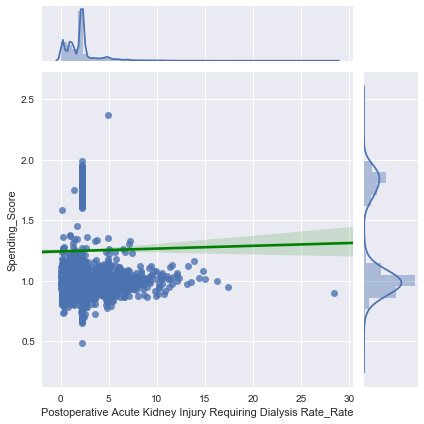

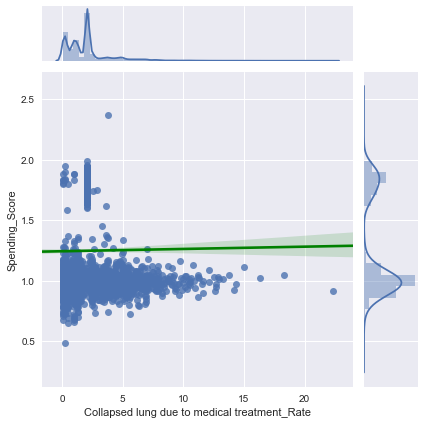

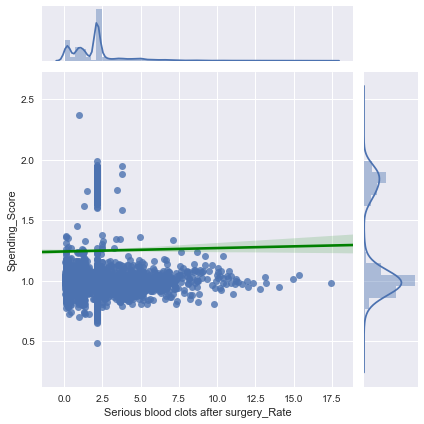

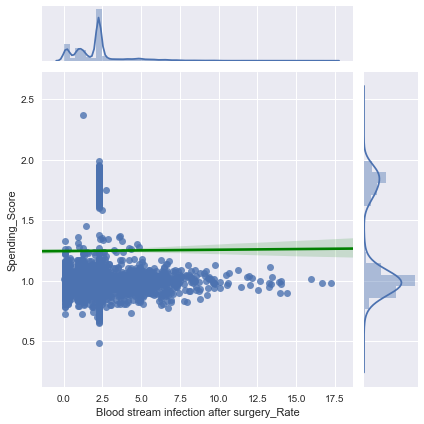

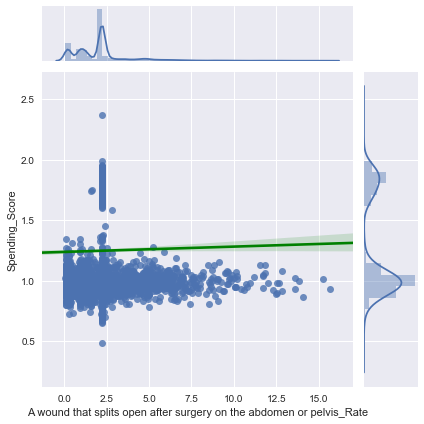

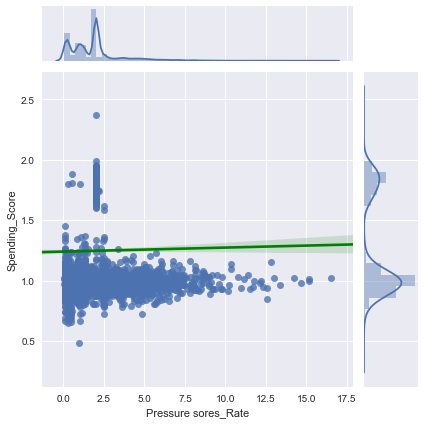

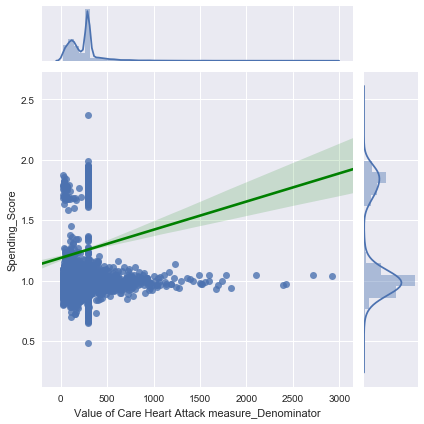

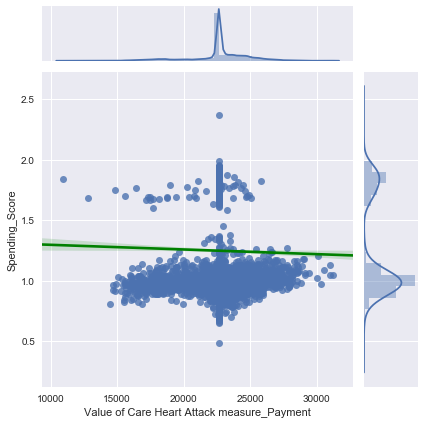

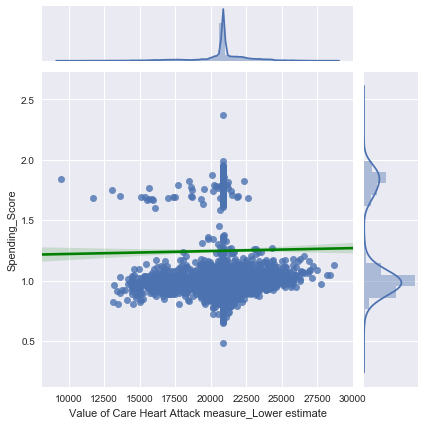

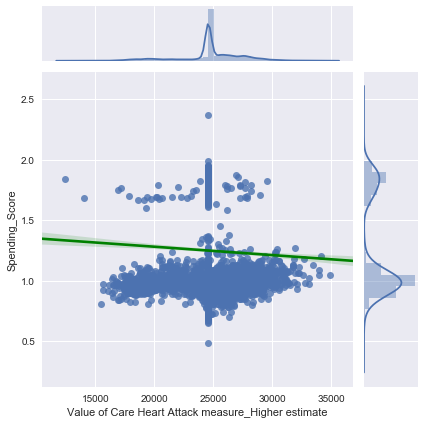

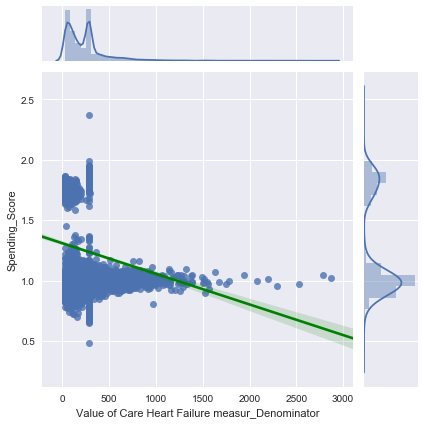

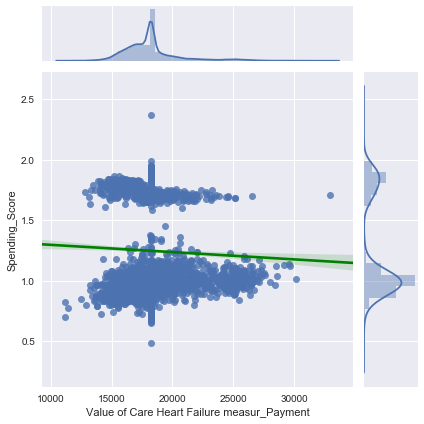

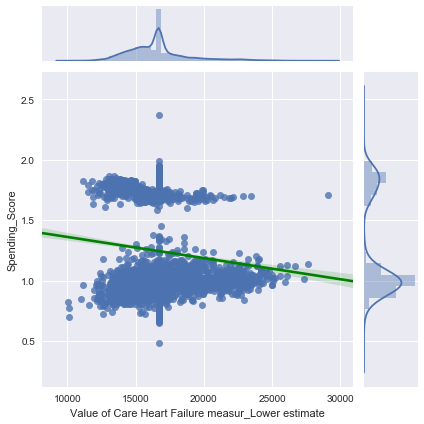

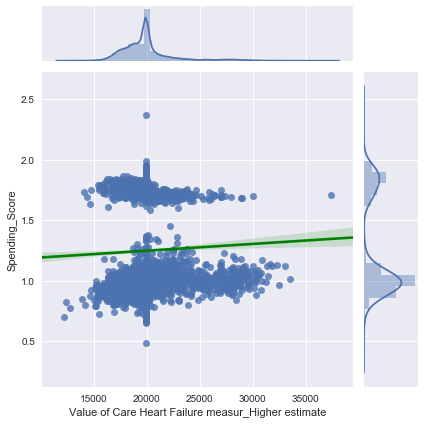

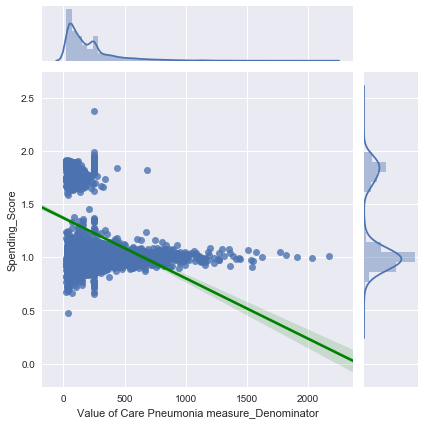

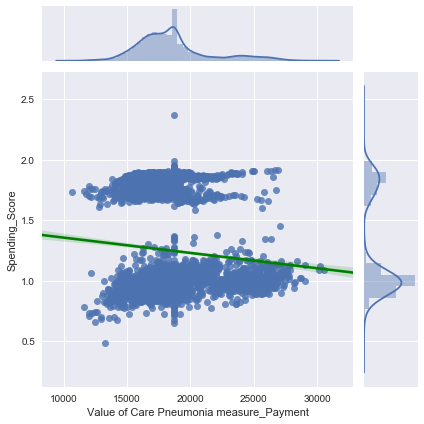

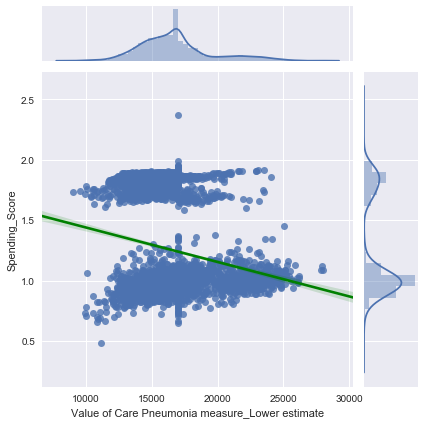

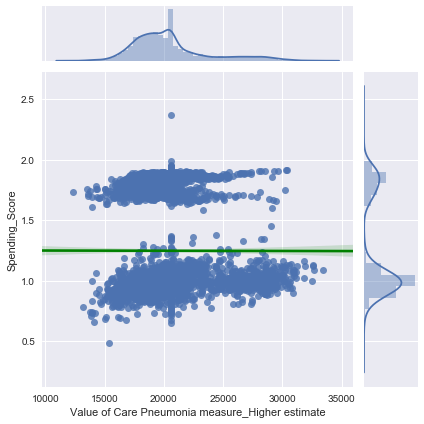

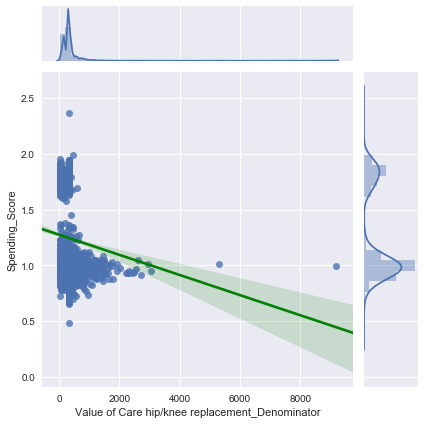

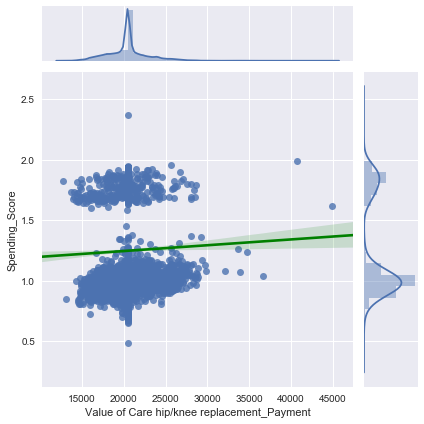

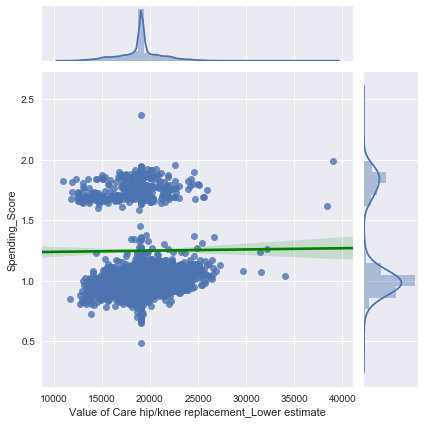

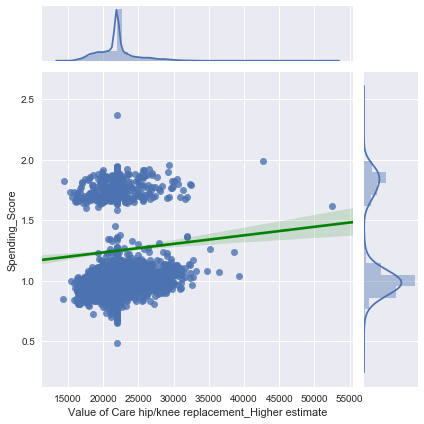

In [28]:
def plot_jointplot(df):
    #plot jointplot for each variable in relation to target
    plt.style.use('seaborn')

    features = df.columns[:-1]
    for col in list(features):
        sns.jointplot(x = df[col], y = df['Spending_Score'], data = df, kind = 'reg', label = col, joint_kws={'line_kws':{'color':'green'}})

plot_jointplot(train)

In [162]:
print(train.shape)
new = train.copy()

#drops rows where data for a given column exceeds a number # of standard deviations
def drop_outliers(df, std):
    columns = df.columns
    outliers= []
    for col in columns[1:-1]:
        std_value = df[col].std()
        mean_value = df[col].mean()
        outlier = df[((df[col] - std_value).abs()) > mean_value + (std_value*std)]
        outliers.append(outlier.index)
    df.drop(outlier.index, axis = 0, inplace =True)
    return df

drop_outliers(new,3)
print(new.shape)

(4026, 130)
(4017, 130)


In [263]:
#Drop anything outside 3 standard deviations (99% of bell curve) which turns out to be only 9 entries
train = drop_outliers(train, 3)

#rescale the features
scaled_train_X = scale_features(train)

At this point, there are still over 140 features within the dataset. Therefore, it would be ideal to reduce the dataset to only columns that have the biggest impact on our data. Both stepwise selection and RFE will be used for this purpose.

In [164]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward`-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))
                
                        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included



In [262]:
train_y = train['Spending_Score']
train_X = train[df.columns[1:-1]]

test_X = test[test.columns[1:-1]]
test_y = test['Spending_Score']

In [255]:
stepwise_result = stepwise_selection(train_X, list(train_y))
len(stepwise_result)

C:\Users\Thien Nguyen\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Add  Death rate for pneumonia patients_Denominator with p-value 4.53296e-141
Add  Broken hip from a fall after surgery_Denominator with p-value 5.34878e-290
Add  Serious blood clots after surgery_Denominator with p-value 3.01517e-59
Add  Death rate for heart attack patients_Denominator with p-value 3.46791e-45
Add  Death rate for heart failure patients_Denominator with p-value 4.50782e-30
Add  Value of Care Heart Attack measure_Denominator with p-value 1.37191e-24
Add  Death rate for pneumonia patients_Higher Estimate with p-value 6.85214e-20
Add  Death rate for pneumonia patients_Score with p-value 2.91111e-153
Add  Death rate for stroke patients_Higher Estimate with p-value 1.32444e-16
Add  Death rate for stroke patients_Score with p-value 3.87726e-20
Add  Pressure sores_Denominator     with p-value 3.06114e-11
Add  Postoperative Respiratory Failure Rate_Denominator with p-value 1.97595e-16
Add  Collapsed lung due to medical treatment_Denominator with p-value 3.77941e-16
Add  Value o

C:\Users\Thien Nguyen\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


Add  Blood stream infection after surgery_Lower Estimate with p-value 3.09631e-06
Add  Blood stream infection after surgery_Higher Estimate with p-value 5.05403e-09
Drop Postoperative Acute Kidney Injury Requiring Dialysis Rate_Denominator with p-value 0.859556
Add  Death rate for pneumonia patients_Lower Estimate with p-value 2.7885e-05
Drop Death rate for pneumonia patients_Score with p-value 0.826907
Add  SSI - Abdominal Hysterectomy: Observed Cases_Score with p-value 0.000346986
Add  Catheter Associated Urinary Tract Infections (ICU + select Wards): Predicted Cases_Score with p-value 0.000432175
Add  MRSA Bacteremia: Predicted Cases_Score with p-value 0.000994666
Add  Central Line Associated Bloodstream Infection: Number of Device Days_Score with p-value 0.00110112
Add  Central Line Associated Bloodstream Infection (ICU + select Wards): Upper Confidence Limit_Score with p-value 0.000866703
Add  Catheter Associated Urinary Tract Infections (ICU + select Wards): Upper Confidence Limi

61

Great! Looks like stepwise selection reduce the dataset down to 61 statistically significant columns according to OLS. However, this is still a bit much, and stepwise selection is known to inflate false positives due to the nature of its algorithm. Therefore', we'll use RFE and set the feature number to only 50, since we want to reduce dimensionality as much as possible.

In [264]:
#RFE feature selection
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE


linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select = 50)
selector = selector.fit(train_X, train_y)

selected_columns = train_X.columns[selector.support_]
selected_columns
rfe_list = selected_columns.get_values().tolist()



C:\Users\Thien Nguyen\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  if sys.path[0] == '':


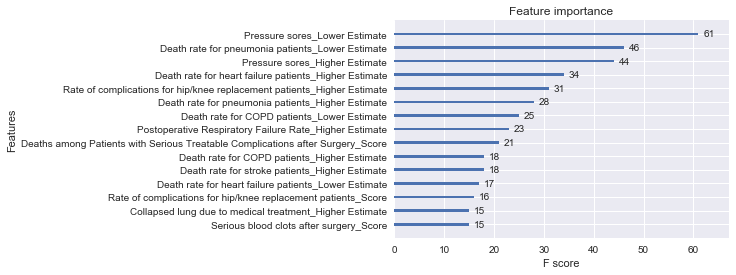

In [291]:
# plot feature importance using built-in function
from numpy import loadtxt
from xgboost import XGBRegressor, XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

rfe_X = train_X[rfe_list]

# fit model no training data
model = XGBRegressor()
model.fit(rfe_X, train_y)

# plot feature importance
plot_importance(model, max_num_features = 15)
#plt.figure(figsize=(20,100))
pyplot.show()

XGBoost's plot importance function gives us a pretty good graph of what features are important according to F-score. Here, the model suggests that collapsed lung and pressure sores are the two biggest indicators of spending score, which is surprising. We will see if OLS modeling supports this. Before that, we'll check for multicollinearity with a heatmap.

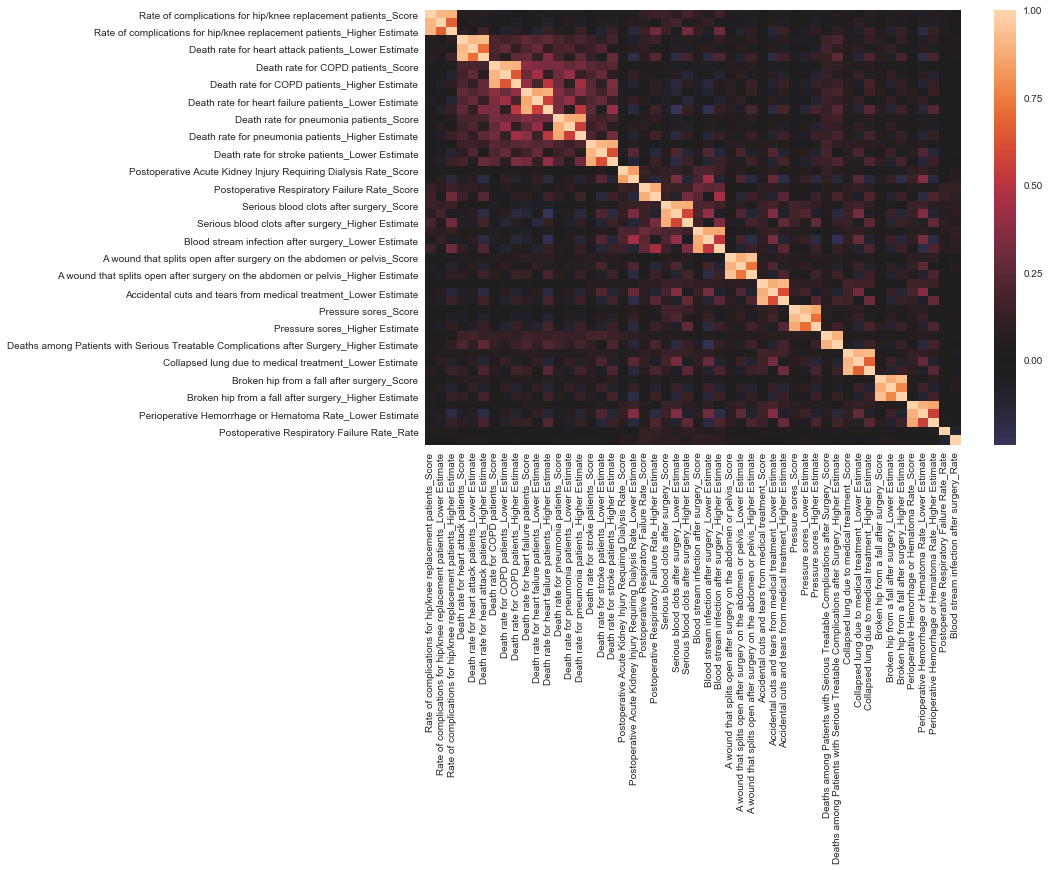

In [266]:
#plot a heatmap with the selected components to recheck multicollinearity
plt.figure(figsize=(12,8))
sns.heatmap(pd.DataFrame(rfe_X).corr(), center = 0)

There is a big issue with multicolinearity. First, since each measure often had 4 different score types--lower estimate, higher estimate, denominator, and score--it is not surprising to see that these measures are highly correlated to each other. Second, some features are inversely correlated with each other, as dictated by the blue.  This will most likely result in some degree of overfitting within the OLS model.

In [267]:
#OLS model + interpret

formula = 'Spending_Score ~'
for feature in rfe_list[:-1]:
    formula += '{} +'.format(feature)
formula += 'Blood stream infection after surgery_Rate' #have to add manually or else the for-loop ends with a '+' sign



ols_model = smf.OLS(formula = formula, exog = train_X, endog = train_y).fit()
ols_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Spending_Score   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     1138.
Date:                Sun, 29 Dec 2019   Prob (F-statistic):               0.00
Time:                        16:58:02   Log-Likelihood:                 546.48
No. Observations:                4015   AIC:                            -837.0
Df Residuals:                    3887   BIC:                            -30.84
Df Model:                         128                                         
Covariance Type:            nonrobust                                         
============================================================================================================================================================================
                                                                                                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Rate of complications for hip/knee replacement patients_Denominator                                         -0.0009   8.56e-05    -10.267      0.000      -0.001      -0.001
Rate of complications for hip/knee replacement patients_Score                                               -0.0865      0.095     -0.908      0.364      -0.273       0.100
Rate of complications for hip/knee replacement patients_Lower Estimate                                       0.0508      0.078      0.649      0.517      -0.103       0.204
Rate of complications for hip/knee replacement patients_Higher Estimate                                      0.0218      0.035      0.624      0.533      -0.047       0.090
Death rate for heart attack patients_Denominator                                                            -0.0007      0.000     -7.128      0.000      -0.001      -0.001
Death rate for heart attack patients_Score                                                                   0.0462      0.071      0.652      0.514      -0.093       0.185
Death rate for heart attack patients_Lower Estimate                                                          0.0329      0.048      0.684      0.494      -0.061       0.127
Death rate for heart attack patients_Higher Estimate                                                        -0.0662      0.030     -2.203      0.028      -0.125      -0.007
Death rate for COPD patients_Denominator                                                                    -0.0002   8.09e-05     -2.286      0.022      -0.000   -2.63e-05
Death rate for COPD patients_Score                                                                          -0.0317      0.057     -0.554      0.580      -0.144       0.081
Death rate for COPD patients_Lower Estimate                                                                 -0.0003      0.043     -0.007      0.995      -0.084       0.084
Death rate for COPD patients_Higher Estimate                                                                 0.0290      0.022      1.308      0.191      -0.014       0.072
Death rate for heart failure patients_Denominator                                                           -0.0012   9.85e-05    -12.217      0.000      -0.001      -0.001
Death rate for heart failure patients_Score                                                                  0.0591      0.048      1.229      0.219      -0.035       0.153
Death rate for heart failure patients_Lower Estimate                                                        -0.0074      0.034     -0.220     

In [221]:
linreg= LinearRegression()
cv_20_results = cross_val_score(linreg, train_X, train_y, cv=20, scoring="neg_mean_squared_error")
print(cv_20_results)
print(np.mean(cv_20_results))

[-0.04363531 -0.03782585 -0.02134578 -0.03138161 -0.03570563 -0.05122063
 -0.03826674 -0.04044347 -0.03265644 -0.02431735 -0.0247865  -0.0380069
 -0.03056426 -0.0369147  -0.02203825 -0.04405224 -0.02726846 -0.0450421
 -0.04245851 -0.38582243]
-0.05268765767547209


In [268]:
ols_preds = ols_model.predict(test_X)

ols_model_r2= r2_score(test_y, ols_preds)

print('R2 score:', ols_model_r2)

R2 score: -3.8296033518401362


### OLS Model Interpretation

The model above explains a lot of the variance within the train data with an adjusted R2 of .973. However, the large condition number suggests that the redundant score types contributed to multicollinearity, and the model is also a bit kurtic. With a 20-fold cross validation, we find that the model itself is pretty well balanced within the train data.

The big kicker is that the r2 score against the test data is horrendous, which heavily points to overfitting. Again, this is most likely due to multicollinearity.

Let's see if we can visualize this disparity.

In [406]:
def pred_error_scatter(y_pred, y_test):

    fig, ax = plt.subplots()

    ax.scatter(x = range(0, y_test.size), y=y_test, c = 'blue', label = 'Actual', alpha = 0.3)
    ax.scatter(x = range(0, y_pred.size), y=y_pred, c = 'red', label = 'Predicted', alpha = 0.3)

    plt.title('Actual and predicted values')
    plt.xlabel('Observations')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

In [432]:
def pred_error_plot(y_pred, y_test):
    fig, ax = plt.subplots()
    ax.scatter(y_test, y_pred, alpha = .5)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label = 'Perfect Fit')
#    ax.plot([y_test.min(), y_test.max()], [y_test.mean(), y_test.mean()], lw =2 , color ='red', label = 'Test Mean')
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.legend()
    plt.show()

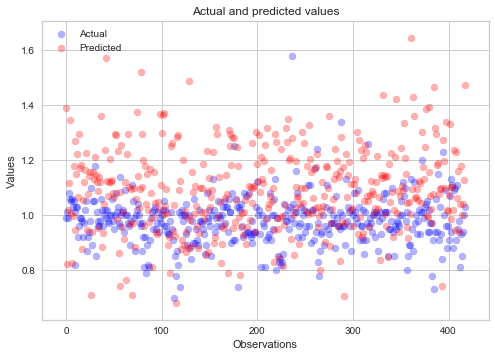

In [428]:
pred_error_scatter(ols_preds, test_y)

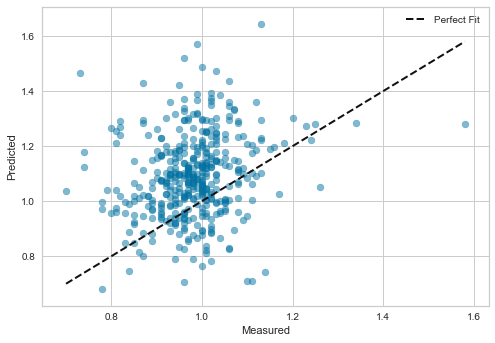

In [433]:
pred_error_plot(ols_preds, test_y)

Both graphs demonstrate how inaccurate the model is at predicting non-imputed, "real" values. This suggests that our imputed dataset might be doomed to fail from the beginning as the test data might inherently vary too greatly from our imputed data. To confirm this and to see if we can mitigate this, let's turn to machine learning.

## Modeling with Machine Learning

### Principal Component Analysis

In [273]:
scaled_X = scale_features(train)

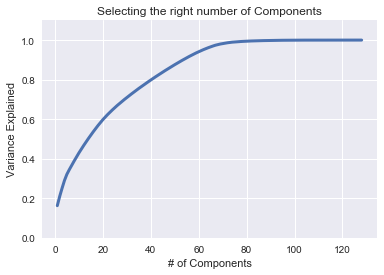

In [274]:
#makes a graph of features to variance explained
def pca_var_graph(scaled_X):

    #Run PCA on the scaled features to reduce dimensionality
    pca = PCA()
    pca.fit(scaled_X)

    #plot a cumulative plot of explain variance to threshold
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    dim = np.arange(len(cumsum))+1

    #graph variance vs features
    plt.plot(dim,cumsum,'-',lw=3);

    plt.xlabel('# of Components')
    plt.ylabel('Variance Explained')
    plt.title('Selecting the right number of Components')

    plt.ylim([0,1.1]);
    
pca_var_graph(scaled_X)

The graph above tells us that instead of using all 130 features, most of the variance in the data can be explained simply with a little more than 60 features, which greatly reduces dimensionality and should make both data exploration and modeling much simpler

In [276]:
variance_thresholds = [.8, .85, .9, .95, .99]

#takes a list of variance threshold and returns how many features are need to explain that variance
def list_var_thres(variance_thresholds, scaled_X):
    #prints the minimum number of principal components needed for each threshold
    for threshold in variance_thresholds:
        pca = PCA (n_components = threshold)
        pca.fit_transform(scaled_X)
        print('{} Principal components are needed to explain {}% of the data'.format(pca.n_components_,threshold*100))
        
list_var_thres(variance_thresholds, scaled_X)

41 Principal components are needed to explain 80.0% of the data
47 Principal components are needed to explain 85.0% of the data
54 Principal components are needed to explain 90.0% of the data
62 Principal components are needed to explain 95.0% of the data
75 Principal components are needed to explain 99.0% of the data


In [278]:
#We'll use 62 since it explain 95% of the variance
n_components = 62

def pca_features(n_components, scaled_X):

    #Run PCA with chosen number of components
    pca = PCA(n_components = n_components)
    X_pca = pca.fit_transform(scaled_X)
    return X_pca

X_pca = pca_features(n_components, scaled_X)


In [280]:
#check the shape
X_pca.shape

(4015, 62)

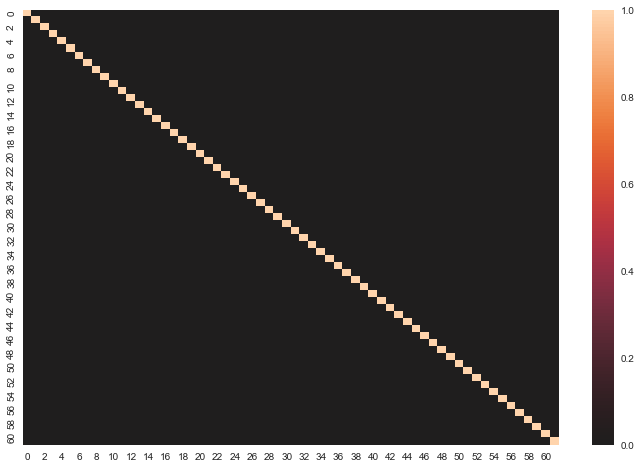

In [279]:
#plot a heatmap with the selected components to recheck multicollinearity
plt.figure(figsize=(12,8))
sns.heatmap(pd.DataFrame(X_pca).corr(), center = 0)

After scaling and PCA, the heat map shows no indication of multicollinearity, which should help against overfitting later on.

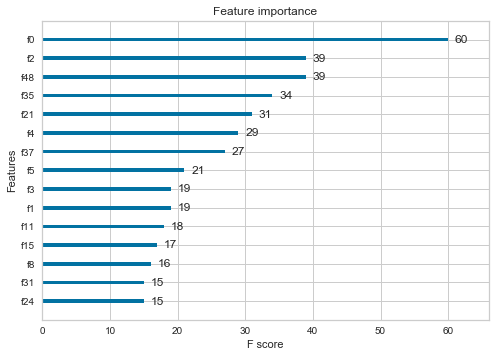

In [535]:
pca_X = X_pca

# fit model no training data
model = XGBRegressor()
model.fit(pca_X, train_y)

# plot feature importance
plot_importance(model, max_num_features = 15)
pyplot.show()

With PCA, features don't quite stay original as they're manipulated by PCA to retain as much variance as possible. So unlike with simple OLS, the feature importance graph doesn't tell us as much as before about which features are best.

# Machine Learning: Random Forest & XGBoost

In [436]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

#This comes from our imputed dataset that we've scaled
train_y = train['Spending_Score']
train_X = train[df.columns[1:-1]]
test_X = test[test.columns[1:-1]]
test_y = test['Spending_Score']

#scale the test
scaled_test_X = scale_features(test)

#The test set is the 10% of data we sectioned off at the beginning
X_train, X_test, y_train, y_test = scaled_X, scaled_test_X, train_y, test_y

#pipeline random forest 
n_components = 62
forest_pipe = Pipeline([('pca', PCA(n_components =n_components)), ('clf', RandomForestRegressor(random_state = 69))])
xg_pipe = Pipeline([('pca', PCA(n_components = n_components)), ('clf', xgb.XGBRegressor(random_state = 69))])

#Create a list to iterate through
pipelines = [forest_pipe, xg_pipe]
pipe_names = ['Random_Forest', 'XGBoost']

#Use a for-loop to fit each pipeline to the training data
for pipe in pipelines:
    pipe.fit(X_train, y_train)

#print out the value score for each pipeline
for i,v in enumerate(pipelines):
    print('{} pipeline test: {}'.format(pipe_names[i], v.score(X_test, y_test)))
    score = cross_val_score(v, X_train, y_train, scoring = 'neg_mean_squared_error', cv=10)
    print('{} pipeline CV score: {}'.format(pipe_names[i], score.mean()))

Random_Forest pipeline test: -0.289083602196748
Random_Forest pipeline CV score: -0.017232785277220292
XGBoost pipeline test: -0.8838225988222894
XGBoost pipeline CV score: -0.018169920102069165


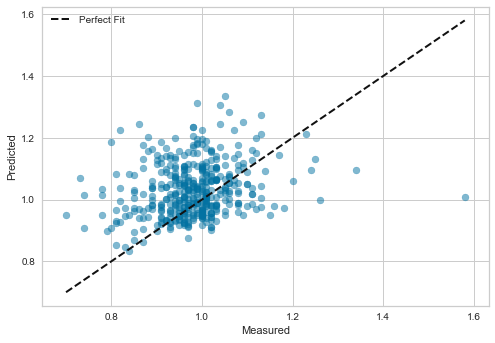

In [437]:
y_pred = xg_pipe.predict(X_test)
pred_error_plot(y_pred, y_test)

### Analysis

Cross validation score for both algorithms were great, which meant that the model was well-trained on the training data. However, this did not translate to the actual test data (which we did not let the model train on). In this case, performance is rather grotesque as the model actually does worse than just choose the mean. This shouldn't be surprising given that there were fewer than 1000 entries not missing null values and that only half of them were split into the training set. This meant that the model could not incorporate enough "true" values to offset the imputed values. Therefore, it's no surprise to see it do so poorly against our test data. Let's see how things change if we simply use the entire dataset without partitioning off a section as test data.

In [438]:
X = df[df.columns[1:-1]]
y = df['Spending_Score']

#perform and 80/20 split on the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 69)

#pipeline random forest 
n_components = 62
forest_pipe = Pipeline([('pca', PCA(n_components =n_components)), ('clf', RandomForestRegressor(random_state = 69))])
xg_pipe = Pipeline([('pca', PCA(n_components = n_components)), ('clf', xgb.XGBRegressor(random_state = 69))])

#Create a list to iterate through
pipelines = [forest_pipe, xg_pipe]
pipe_names = ['Random_Forest', 'XGBoost']

#Use a for-loop to fit each pipeline to the training data
for pipe in pipelines:
    pipe.fit(X_train, y_train)

#print out the value score for each pipeline
for i,v in enumerate(pipelines):
    print('{} pipeline test score: {}'.format(pipe_names[i], v.score(X_test, y_test)))
    score = cross_val_score(v, X_train, y_train, scoring = 'neg_mean_squared_error', cv=10)
    print('{} pipeline CV score: {}'.format(pipe_names[i], score.mean()))

Random_Forest pipeline test score: 0.9072374246541998
Random_Forest pipeline CV score: -0.014939075078169741
XGBoost pipeline test score: 0.9109459342235317
XGBoost pipeline CV score: -0.014682315015158293


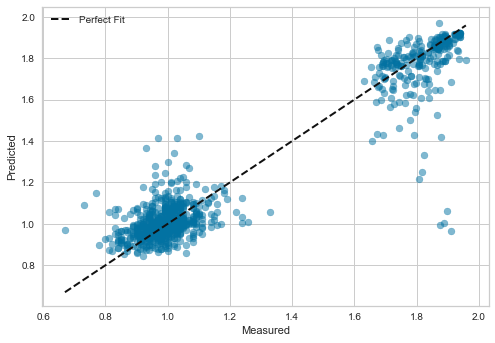

In [439]:
y_pred = xg_pipe.predict(X_test)
pred_error_plot(y_pred, y_test)

### Analysis

Cross validation was about the same, which suggested that the algorithm performed similarly as before with the training set. However, the test score improved immensely for two reasons. First, the models were allowed to train on twice as much "real" data that was not imputed, which allowed it to learn different trends. Second, the test set itself was a mixture of imputed and real data that resembled the training data. However, this test set is more superficial than the previous test set because it is more superficial. In this case, our models are internally valid, but lack external validity because its prediction is predicated on an impure mix of "real" and imputed values.

At this point, it is clear that the non-null test data is **too** different from our imputed dataset, such that no matter what model we run, the difference between predict and actual value will always be vastly different. However, for the sake of it, we shall try our hand at deep learning. 

# Deep Learning

In [441]:
#Import necessary libraries for deep learning

import tensorflow as tf
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers, models
from keras.preprocessing import text, sequence
from keras.callbacks import ModelCheckpoint, EarlyStopping
import os, shutil
from glob import glob
import fileinput
from collections import defaultdict
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.applications import VGG19, inception_v3
from sklearn.metrics import confusion_matrix
import itertools
import random as rn
import pydot
import graphviz

Using TensorFlow backend.


In [ ]:
#saves the best model weights based on the loss value; checkpoint path will be renamed for each different model if used
checkpoints_path = 'weights_base.best.hdf5'
checkpoint = ModelCheckpoint(checkpoints_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

#stops the model if model does not improve after 10 epochs
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10)

callbacks = [checkpoint, early_stopping]

In [505]:
cnn_model = models.Sequential()
cnn_model.add(Dense(13, input_dim=128, kernel_initializer='normal', activation='relu'))
cnn_model.add(Dense(64, kernel_initializer='normal'))
cnn_model.add(Dense(128, kernel_initializer='normal'))
cnn_model.add(Dense(1, activation = 'relu'))


In [506]:
#compiles the model
cnn_model.compile(loss='mean_squared_error',
              optimizer="adam",
              metrics=['acc','mse'])

cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 13)                1677      
_________________________________________________________________
dense_35 (Dense)             (None, 64)                896       
_________________________________________________________________
dense_36 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 129       
Total params: 11,022
Trainable params: 11,022
Non-trainable params: 0
_________________________________________________________________


In [509]:
cnn_train= train[train.columns[1:-1]]
cnn_train_y = train['Spending_Score']
cnn_test = test[test.columns[1:-1]]
cnn_test_y = test['Spending_Score']

history = cnn_model.fit(cnn_train, cnn_train_y, epochs=20, batch_size=16, validation_split = 0.2)


Train on 3212 samples, validate on 803 samples
Epoch 1/20
3212/3212 [==============================] - 0s 70us/step - loss: 1.3205 - acc: 0.0000e+00 - mean_squared_error: 1.3205 - val_loss: 3.2993 - val_acc: 0.0000e+00 - val_mean_squared_error: 3.2993
Epoch 2/20
3212/3212 [==============================] - 0s 67us/step - loss: 1.3205 - acc: 0.0000e+00 - mean_squared_error: 1.3205 - val_loss: 3.2993 - val_acc: 0.0000e+00 - val_mean_squared_error: 3.2993
Epoch 3/20
3212/3212 [==============================] - 0s 64us/step - loss: 1.3205 - acc: 0.0000e+00 - mean_squared_error: 1.3205 - val_loss: 3.2993 - val_acc: 0.0000e+00 - val_mean_squared_error: 3.2993
Epoch 4/20
3212/3212 [==============================] - 0s 72us/step - loss: 1.3205 - acc: 0.0000e+00 - mean_squared_error: 1.3205 - val_loss: 3.2993 - val_acc: 0.0000e+00 - val_mean_squared_error: 3.2993
Epoch 5/20
3212/3212 [==============================] - 0s 71us/step - loss: 1.3205 - acc: 0.0000e+00 - mean_squared_error: 1.3205 - 

In [522]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()

val_loss  val_acc  val_mean_squared_error      loss  acc  \
0  3.299313      0.0                3.299313  1.320547  0.0   
1  3.299313      0.0                3.299313  1.320547  0.0   
2  3.299313      0.0                3.299313  1.320547  0.0   
3  3.299313      0.0                3.299313  1.320547  0.0   
4  3.299313      0.0                3.299313  1.320547  0.0   

   mean_squared_error  epoch  
0            1.320547      0  
1            1.320547      1  
2            1.320547      2  
3            1.320547      3  
4            1.320547      4

In [523]:
loss, mae, mse = cnn_model.evaluate(cnn_test, test['Spending_Score'], verbose=2)
print("Testing set Mean abs Error: {:5.2f} ".format(mae))
print("Testing set Mean squared Error: {:5.2f} ".format(mse))
print("Testing set loss: {:5.2f} ".format(loss))


Testing set Mean abs Error:  0.00 
Testing set Mean squared Error:  0.97 
Testing set loss:  0.97 


In [532]:
cnn_model.predict(cnn_test)


TypeError: data type not understood

## Conclusion

Without less than 1000 entries without any NaN values (ie. the pure data), it was a bit too hopeful that a suitable model could be constructed from a dataframe where over 1/3 of the values were KNN imputed. There was simply too much data loss for any model to find meaningful trends in the data. Cross validation using just training data indicated minimal loss, but when tested against the pure data, all models fail. To further prove this, both machine learning models that performed adequately only did so because the test data set was a combination of pure data and imputed data.

The lesson here is that the first step of the OSEMN process is indeed the most important -- obtaining data in both quality and quantity. This investigation tried to make up for the lack of data via imputation, but algorithms are not magic; they cannot simply fill-in what is supposed to be real world data. Hence, it is sadly inconclusive.

## Future Considerations

Hospital data continues to be quite secretive due to patient confidentiality and backdoor dealings within the medical system to purposely hide such financial information, but it is undeniable that more data was simply necessary. In the absence of that option (due to either time or financial constraints), a different option might have been to used a different target that was not missing as many values, but is still correlated to the original target. This might not lend as much external validity, but a better model could possibly be made.

# Project Summary

1. Imported both imputed and pure df created from the first notebook.
2. Incorporated half of the pure into the imputed df to make the train dataset, while the other half was the test dataset.
3. Explored histogram and jointplots of the many features and scaled features.
4. Used stepwise selection and RFE for feature selection.
5. Constructed heatmap to check for multicollinearity.
6. Created OLS regression model with an r2 of -3.8 when tested against the test dataset
7. Investigated optimal components for PCA Analysis:
    1. Decided on 62 components, which explained 95% of variance in test data
8. Pipelined data through XGBoost and RandomForest with PCA
    1. Random Forest and XGBoost received a test score of -.28 and -.88 respectively
9. Repeated pipeline with comprehensive dataset and allowed random split
    1. Random Forest and XGBoost received a test score of .90 and .91 respectively.